# Monitoramento de Treinamento com MLflow em Redes Neurais Keras

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical 
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.datasets import mnist
import mlflow
import mlflow.tensorflow

2025-04-23 16:45:06.267172: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 16:45:06.267868: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 16:45:06.271846: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 16:45:06.282372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745437506.299572  438496 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745437506.30

In [2]:
print(tf.__version__)


2.18.0


**Atenção**: O MLflow ainda não tinha suporte oficial ainda pro TensorFlow 2.19, e isso pode quebrar o autolog silenciosamente (sem erro direto, só não registra nada no MLflow). Instalar a versão anterior com: `pip install tensorflow==2.18.0`


Text(0.5, 1.0, '7')

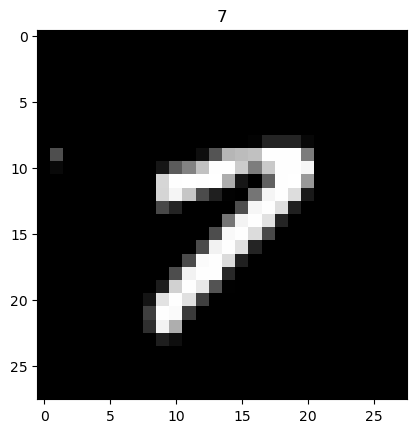

In [4]:
(X_treinamento, y_treinamento),(X_teste, y_teste) = mnist.load_data()
plt.imshow(X_treinamento[29],cmap='gray')
plt.title(y_treinamento[29])

In [5]:
X_treinamento = X_treinamento.reshape((len(X_treinamento), np.prod(X_treinamento.shape[1:])))
X_teste = X_teste.reshape((len(X_teste), np.prod(X_teste.shape[1:])))

In [6]:
X_teste[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [7]:
X_treinamento = X_treinamento.astype('float32') / 255
X_teste = X_teste.astype('float32') / 255

In [8]:
y_treinamento = to_categorical(y_treinamento,10)
y_teste = to_categorical(y_teste,10)

In [9]:
y_teste[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [10]:
def treina_dl(n_camadas_ocultas,n_units,activation,drop_out, epochs):
    mlflow.set_experiment("DLExperimento")
    
    with mlflow.start_run():
        mlflow.tensorflow.autolog()
        
        #registro de tags
        mlflow.set_tag("n_camadas_ocultas",n_camadas_ocultas)
        mlflow.set_tag("n_units",n_units)
        mlflow.set_tag("activation",activation)
        mlflow.set_tag("drop_out",drop_out)
        mlflow.set_tag("epochs",epochs)

    
        modelo = Sequential()
        
        #cria camada oculta mais camada de entrada
        modelo.add(Dense(units=n_units, activation=activation, input_dim=784))
        modelo.add(Dropout(drop_out))
        
        #camadas ocultas adicionais, com drop out
        for n in range(n_camadas_ocultas):
            modelo.add(Dense(units=n_units, activation=activation))
            modelo.add(Dropout(drop_out))            
        
        #camada de saída
        modelo.add(Dense(units=10,activation='softmax'))
        
        modelo.compile(optimizer='adam', loss="categorical_crossentropy",metrics=['accuracy'])
        
        modelo.summary()
        
        historico = modelo.fit(X_treinamento, y_treinamento, epochs =epochs, 
                              validation_data=(X_teste,y_teste))
        
        #grafico para erros e acuracia
        historico.history.keys()
        loss = plt.plot(historico.history['val_loss'])
        plt.savefig("loss.png")
        acuracia = plt.plot(historico.history['val_accuracy'])
        plt.savefig("acuracia.png")
        
        #registrar artefatos
        mlflow.log_artifact("loss.png")
        mlflow.log_artifact("acuracia.png")
       
        #informações de execução
        print("Modelo: ", mlflow.active_run().info.run_uuid)  
    mlflow.end_run()           
        

/home/thiago-tim/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-23 16:45:10.266093: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,002 (50.79 KB)

 Trainable params: 13,002 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6607 - loss: 1.0306

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6618 - loss: 1.0275 - val_accuracy: 0.9122 - val_loss: 0.3080
Epoch 2/5
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8692 - loss: 0.4332

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8692 - loss: 0.4331 - val_accuracy: 0.9276 - val_loss: 0.2499
Epoch 3/5
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8863 - loss: 0.3774

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8863 - loss: 0.3774 - val_accuracy: 0.9292 - val_loss: 0.2402
Epoch 4/5
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8955 - loss: 0.3400

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8955 - loss: 0.3401 - val_accuracy: 0.9328 - val_loss: 0.2229
Epoch 5/5
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8988 - loss: 0.3263

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8988 - loss: 0.3263 - val_accuracy: 0.9371 - val_loss: 0.2130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Modelo:  2424ab07c1e545bdabdaa1d3ee4b5197


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,002 (50.79 KB)

 Trainable params: 13,002 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6580 - loss: 1.0341

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6584 - loss: 1.0328 - val_accuracy: 0.9081 - val_loss: 0.3166
Epoch 2/10
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8539 - loss: 0.4624

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8540 - loss: 0.4623 - val_accuracy: 0.9235 - val_loss: 0.2632
Epoch 3/10
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8787 - loss: 0.3913

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8787 - loss: 0.3913 - val_accuracy: 0.9263 - val_loss: 0.2467
Epoch 4/10
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8897 - loss: 0.3572

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8897 - loss: 0.3572 - val_accuracy: 0.9324 - val_loss: 0.2235
Epoch 5/10
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8905 - loss: 0.3559

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8905 - loss: 0.3559 - val_accuracy: 0.9329 - val_loss: 0.2235
Epoch 6/10
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8966 - loss: 0.3334

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8966 - loss: 0.3334 - val_accuracy: 0.9331 - val_loss: 0.2179
Epoch 7/10
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8994 - loss: 0.3174

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8994 - loss: 0.3175 - val_accuracy: 0.9360 - val_loss: 0.2058
Epoch 8/10
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9017 - loss: 0.3168

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9017 - loss: 0.3168 - val_accuracy: 0.9370 - val_loss: 0.2050
Epoch 9/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9051 - loss: 0.3059

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9051 - loss: 0.3059 - val_accuracy: 0.9394 - val_loss: 0.1966
Epoch 10/10
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9082 - loss: 0.2973

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9082 - loss: 0.2973 - val_accuracy: 0.9402 - val_loss: 0.1942
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Modelo:  b23a9c8c2f7b4a618bc4f042bedd8d6c


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,002 (50.79 KB)

 Trainable params: 13,002 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6778 - loss: 0.9687

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6785 - loss: 0.9665 - val_accuracy: 0.9246 - val_loss: 0.2549
Epoch 2/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8794 - loss: 0.3882

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8794 - loss: 0.3881 - val_accuracy: 0.9315 - val_loss: 0.2265
Epoch 3/20
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8940 - loss: 0.3461

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8940 - loss: 0.3461 - val_accuracy: 0.9374 - val_loss: 0.2147
Epoch 4/20
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9007 - loss: 0.3210

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9007 - loss: 0.3210 - val_accuracy: 0.9408 - val_loss: 0.2044
Epoch 5/20
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9044 - loss: 0.3048

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9045 - loss: 0.3048 - val_accuracy: 0.9446 - val_loss: 0.1930
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9074 - loss: 0.2998 - val_accuracy: 0.9419 - val_loss: 0.2006
Epoch 7/20
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9110 - loss: 0.2862

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9110 - loss: 0.2862 - val_accuracy: 0.9451 - val_loss: 0.1875
Epoch 8/20
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9120 - loss: 0.2823

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9120 - loss: 0.2823 - val_accuracy: 0.9474 - val_loss: 0.1806
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9140 - loss: 0.2718 - val_accuracy: 0.9469 - val_loss: 0.1828
Epoch 10/20
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9187 - loss: 0.2633

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9187 - loss: 0.2633 - val_accuracy: 0.9470 - val_loss: 0.1788
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9196 - loss: 0.2619 - val_accuracy: 0.9477 - val_loss: 0.1823
Epoch 12/20
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9178 - loss: 0.2574

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9178 - loss: 0.2574 - val_accuracy: 0.9485 - val_loss: 0.1739
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9224 - loss: 0.2543 - val_accuracy: 0.9487 - val_loss: 0.1769
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9215 - loss: 0.2464 - val_accuracy: 0.9476 - val_loss: 0.1771
Epoch 15/20
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9256 - loss: 0.2431

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9256 - loss: 0.2431 - val_accuracy: 0.9506 - val_loss: 0.1716
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9227 - loss: 0.2442 - val_accuracy: 0.9491 - val_loss: 0.1780
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9252 - loss: 0.2415 - val_accuracy: 0.9494 - val_loss: 0.1762
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9276 - loss: 0.2361 - val_accuracy: 0.9512 - val_loss: 0.1781
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9265 - loss: 0.2376 - val_accuracy: 0.9499 - val_loss: 0.1795
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9270 - loss: 0.2339 - val_accuracy: 0.9518 - val_loss: 0.1792
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Modelo:  6d075610c76a49efa8e3b5e98ce48b52


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,002 (50.79 KB)

 Trainable params: 13,002 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5870 - loss: 1.2289

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5878 - loss: 1.2267 - val_accuracy: 0.9113 - val_loss: 0.3233
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8087 - loss: 0.5910

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8087 - loss: 0.5910 - val_accuracy: 0.9189 - val_loss: 0.2799
Epoch 3/5
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8303 - loss: 0.5326

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8303 - loss: 0.5325 - val_accuracy: 0.9250 - val_loss: 0.2603
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8448 - loss: 0.4924 - val_accuracy: 0.9243 - val_loss: 0.2619
Epoch 5/5
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8559 - loss: 0.4609

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8559 - loss: 0.4609 - val_accuracy: 0.9316 - val_loss: 0.2374
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Modelo:  49edf8f08bbf470f9d0cecc6c2ee0f54


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,002 (50.79 KB)

 Trainable params: 13,002 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5797 - loss: 1.2335

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5813 - loss: 1.2291 - val_accuracy: 0.9022 - val_loss: 0.3647
Epoch 2/10
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8033 - loss: 0.6214

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8034 - loss: 0.6213 - val_accuracy: 0.9176 - val_loss: 0.2966
Epoch 3/10
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8248 - loss: 0.5600

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8249 - loss: 0.5598 - val_accuracy: 0.9227 - val_loss: 0.2773
Epoch 4/10
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8356 - loss: 0.5240

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8356 - loss: 0.5240 - val_accuracy: 0.9229 - val_loss: 0.2668
Epoch 5/10
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8388 - loss: 0.5122

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8388 - loss: 0.5121 - val_accuracy: 0.9272 - val_loss: 0.2524
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8433 - loss: 0.4949 - val_accuracy: 0.9289 - val_loss: 0.2548
Epoch 7/10
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8477 - loss: 0.4765

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8477 - loss: 0.4766 - val_accuracy: 0.9290 - val_loss: 0.2523
Epoch 8/10
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8508 - loss: 0.4695

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8508 - loss: 0.4695 - val_accuracy: 0.9267 - val_loss: 0.2487
Epoch 9/10
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8532 - loss: 0.4624

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8532 - loss: 0.4624 - val_accuracy: 0.9301 - val_loss: 0.2391
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8578 - loss: 0.4464 - val_accuracy: 0.9276 - val_loss: 0.2482


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Modelo:  f63aaf85bd35489bb1ed396fca634953


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,002 (50.79 KB)

 Trainable params: 13,002 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5871 - loss: 1.1945

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5881 - loss: 1.1917 - val_accuracy: 0.9124 - val_loss: 0.3133
Epoch 2/20
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8197 - loss: 0.5684

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8197 - loss: 0.5683 - val_accuracy: 0.9248 - val_loss: 0.2592
Epoch 3/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8345 - loss: 0.5172

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8345 - loss: 0.5172 - val_accuracy: 0.9301 - val_loss: 0.2444
Epoch 4/20
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8507 - loss: 0.4811

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8507 - loss: 0.4811 - val_accuracy: 0.9322 - val_loss: 0.2332
Epoch 5/20
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8552 - loss: 0.4605

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8552 - loss: 0.4605 - val_accuracy: 0.9362 - val_loss: 0.2232
Epoch 6/20
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8583 - loss: 0.4555

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8584 - loss: 0.4554 - val_accuracy: 0.9394 - val_loss: 0.2200
Epoch 7/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8596 - loss: 0.4474

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8596 - loss: 0.4473 - val_accuracy: 0.9366 - val_loss: 0.2156
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8664 - loss: 0.4230 - val_accuracy: 0.9354 - val_loss: 0.2248
Epoch 9/20
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8678 - loss: 0.4240

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8678 - loss: 0.4240 - val_accuracy: 0.9383 - val_loss: 0.2092
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8714 - loss: 0.4133 - val_accuracy: 0.9385 - val_loss: 0.2173
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8724 - loss: 0.4101 - val_accuracy: 0.9400 - val_loss: 0.2149
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8710 - loss: 0.4120 - val_accuracy: 0.9391 - val_loss: 0.2104
Epoch 13/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8724 - loss: 0.4125

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8724 - loss: 0.4124 - val_accuracy: 0.9411 - val_loss: 0.2088
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8758 - loss: 0.3945 - val_accuracy: 0.9401 - val_loss: 0.2150
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8742 - loss: 0.3959 - val_accuracy: 0.9403 - val_loss: 0.2138
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8773 - loss: 0.3945 - val_accuracy: 0.9402 - val_loss: 0.2136
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8786 - loss: 0.3949 - val_accuracy: 0.9392 - val_loss: 0.2158
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8758 - loss: 0.3979 - val_accuracy: 0.9391 - val_loss: 0.2151
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8798 - loss: 0.3906 - val_accuracy: 0.9405 - val_loss: 0.2145
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8805 - loss: 0.3804 - val_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Modelo:  bd44184de2f14f109580e3ade6c2a32a


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,002 (50.79 KB)

 Trainable params: 13,002 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7701 - loss: 0.8816

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7706 - loss: 0.8798 - val_accuracy: 0.9167 - val_loss: 0.2898
Epoch 2/5
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9038 - loss: 0.3363

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9038 - loss: 0.3362 - val_accuracy: 0.9240 - val_loss: 0.2555
Epoch 3/5
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9105 - loss: 0.3070

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9105 - loss: 0.3070 - val_accuracy: 0.9288 - val_loss: 0.2332
Epoch 4/5
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9173 - loss: 0.2780

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9173 - loss: 0.2780 - val_accuracy: 0.9338 - val_loss: 0.2197
Epoch 5/5
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9211 - loss: 0.2730

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9211 - loss: 0.2729 - val_accuracy: 0.9425 - val_loss: 0.1996
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Modelo:  414a093e40174ae2b43bf1b07cf0acbf


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,002 (50.79 KB)

 Trainable params: 13,002 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7567 - loss: 0.8771

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7579 - loss: 0.8728 - val_accuracy: 0.9198 - val_loss: 0.2764
Epoch 2/10
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9042 - loss: 0.3306

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9043 - loss: 0.3304 - val_accuracy: 0.9318 - val_loss: 0.2287
Epoch 3/10
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9155 - loss: 0.2882

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9155 - loss: 0.2883 - val_accuracy: 0.9345 - val_loss: 0.2234
Epoch 4/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9198 - loss: 0.2749

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9198 - loss: 0.2749 - val_accuracy: 0.9395 - val_loss: 0.2089
Epoch 5/10
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9233 - loss: 0.2599

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9233 - loss: 0.2599 - val_accuracy: 0.9413 - val_loss: 0.2034
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9237 - loss: 0.2597

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9237 - loss: 0.2597 - val_accuracy: 0.9422 - val_loss: 0.2000
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9263 - loss: 0.2455 - val_accuracy: 0.9395 - val_loss: 0.2018
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9264 - loss: 0.2451 - val_accuracy: 0.9423 - val_loss: 0.2001
Epoch 9/10
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9295 - loss: 0.2355

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9295 - loss: 0.2356 - val_accuracy: 0.9450 - val_loss: 0.1927
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9290 - loss: 0.2371 - val_accuracy: 0.9412 - val_loss: 0.2035
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Modelo:  b8c12258fe6942a589ca409ce7f3fba2


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,002 (50.79 KB)

 Trainable params: 13,002 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7760 - loss: 0.8632

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7760 - loss: 0.8630 - val_accuracy: 0.9207 - val_loss: 0.2728
Epoch 2/20
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9056 - loss: 0.3241

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9056 - loss: 0.3240 - val_accuracy: 0.9302 - val_loss: 0.2404
Epoch 3/20
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9134 - loss: 0.2914

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9134 - loss: 0.2913 - val_accuracy: 0.9340 - val_loss: 0.2252
Epoch 4/20
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9174 - loss: 0.2737

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9174 - loss: 0.2737 - val_accuracy: 0.9382 - val_loss: 0.2123
Epoch 5/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9201 - loss: 0.2643

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9201 - loss: 0.2643 - val_accuracy: 0.9373 - val_loss: 0.2092
Epoch 6/20
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9253 - loss: 0.2519

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9253 - loss: 0.2519 - val_accuracy: 0.9392 - val_loss: 0.2072
Epoch 7/20
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9254 - loss: 0.2496

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9254 - loss: 0.2496 - val_accuracy: 0.9381 - val_loss: 0.2050
Epoch 8/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9277 - loss: 0.2368

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9277 - loss: 0.2368 - val_accuracy: 0.9407 - val_loss: 0.1924
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9308 - loss: 0.2311 - val_accuracy: 0.9416 - val_loss: 0.1935
Epoch 10/20
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9306 - loss: 0.2308

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9306 - loss: 0.2308 - val_accuracy: 0.9426 - val_loss: 0.1902
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9308 - loss: 0.2270 - val_accuracy: 0.9421 - val_loss: 0.1916
Epoch 12/20
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9327 - loss: 0.2273

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9327 - loss: 0.2273 - val_accuracy: 0.9442 - val_loss: 0.1892
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9348 - loss: 0.2192 - val_accuracy: 0.9445 - val_loss: 0.1892
Epoch 14/20
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9334 - loss: 0.2188

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9334 - loss: 0.2188 - val_accuracy: 0.9438 - val_loss: 0.1876
Epoch 15/20
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9365 - loss: 0.2133

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9365 - loss: 0.2133 - val_accuracy: 0.9456 - val_loss: 0.1834
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9332 - loss: 0.2200 - val_accuracy: 0.9440 - val_loss: 0.1867
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9339 - loss: 0.2165 - val_accuracy: 0.9440 - val_loss: 0.1887
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9364 - loss: 0.2092 - val_accuracy: 0.9443 - val_loss: 0.1879
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9352 - loss: 0.2129 - val_accuracy: 0.9445 - val_loss: 0.1857
Epoch 20/20
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9352 - loss: 0.2063

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9352 - loss: 0.2063 - val_accuracy: 0.9471 - val_loss: 0.1780
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Modelo:  02af0842eb364f46a75b846e8cbf810c


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,002 (50.79 KB)

 Trainable params: 13,002 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7307 - loss: 0.9625

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7314 - loss: 0.9601 - val_accuracy: 0.9108 - val_loss: 0.3147
Epoch 2/5
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8726 - loss: 0.4385

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8726 - loss: 0.4385 - val_accuracy: 0.9200 - val_loss: 0.2770
Epoch 3/5
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8863 - loss: 0.3997

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8863 - loss: 0.3997 - val_accuracy: 0.9239 - val_loss: 0.2563
Epoch 4/5
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8902 - loss: 0.3858

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8902 - loss: 0.3857 - val_accuracy: 0.9281 - val_loss: 0.2512
Epoch 5/5
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8964 - loss: 0.3616

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8964 - loss: 0.3617 - val_accuracy: 0.9302 - val_loss: 0.2387
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Modelo:  45f246591ddc4bf0b0d4d0af563ffceb


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,002 (50.79 KB)

 Trainable params: 13,002 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7166 - loss: 0.9891

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7175 - loss: 0.9861 - val_accuracy: 0.9083 - val_loss: 0.3108
Epoch 2/10
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8737 - loss: 0.4359

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8737 - loss: 0.4359 - val_accuracy: 0.9209 - val_loss: 0.2668
Epoch 3/10
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8872 - loss: 0.3848

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8872 - loss: 0.3848 - val_accuracy: 0.9255 - val_loss: 0.2561
Epoch 4/10
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8920 - loss: 0.3738

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8919 - loss: 0.3738 - val_accuracy: 0.9272 - val_loss: 0.2465
Epoch 5/10
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8966 - loss: 0.3530

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8966 - loss: 0.3531 - val_accuracy: 0.9323 - val_loss: 0.2365
Epoch 6/10
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8998 - loss: 0.3462

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8998 - loss: 0.3462 - val_accuracy: 0.9330 - val_loss: 0.2273
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9018 - loss: 0.3345 - val_accuracy: 0.9354 - val_loss: 0.2289
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9003 - loss: 0.3434 - val_accuracy: 0.9343 - val_loss: 0.2320
Epoch 9/10
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9019 - loss: 0.3333

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9019 - loss: 0.3333 - val_accuracy: 0.9354 - val_loss: 0.2256
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9063 - loss: 0.3252 - val_accuracy: 0.9350 - val_loss: 0.2278
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Modelo:  05a95206d62c4997bb56b35ff81290da


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,002 (50.79 KB)

 Trainable params: 13,002 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7323 - loss: 0.9474

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7334 - loss: 0.9436 - val_accuracy: 0.9097 - val_loss: 0.3099
Epoch 2/20
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8771 - loss: 0.4207

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8771 - loss: 0.4207 - val_accuracy: 0.9208 - val_loss: 0.2693
Epoch 3/20
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8892 - loss: 0.3832

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8892 - loss: 0.3832 - val_accuracy: 0.9239 - val_loss: 0.2598
Epoch 4/20
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8931 - loss: 0.3704

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8931 - loss: 0.3704 - val_accuracy: 0.9267 - val_loss: 0.2465
Epoch 5/20
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8962 - loss: 0.3587

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8962 - loss: 0.3586 - val_accuracy: 0.9294 - val_loss: 0.2394
Epoch 6/20
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8979 - loss: 0.3491

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8979 - loss: 0.3491 - val_accuracy: 0.9288 - val_loss: 0.2363
Epoch 7/20
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9019 - loss: 0.3377

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9019 - loss: 0.3377 - val_accuracy: 0.9299 - val_loss: 0.2348
Epoch 8/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9033 - loss: 0.3321

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9033 - loss: 0.3321 - val_accuracy: 0.9315 - val_loss: 0.2289
Epoch 9/20
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9029 - loss: 0.3316

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9029 - loss: 0.3316 - val_accuracy: 0.9329 - val_loss: 0.2259
Epoch 10/20
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9033 - loss: 0.3343

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9033 - loss: 0.3343 - val_accuracy: 0.9340 - val_loss: 0.2202
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9053 - loss: 0.3229 - val_accuracy: 0.9336 - val_loss: 0.2220
Epoch 12/20
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9032 - loss: 0.3251

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9032 - loss: 0.3251 - val_accuracy: 0.9344 - val_loss: 0.2134
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9072 - loss: 0.3125 - val_accuracy: 0.9352 - val_loss: 0.2161
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9073 - loss: 0.3132 - val_accuracy: 0.9360 - val_loss: 0.2142
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9076 - loss: 0.3136 - val_accuracy: 0.9334 - val_loss: 0.2187
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9076 - loss: 0.3082 - val_accuracy: 0.9344 - val_loss: 0.2228
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9072 - loss: 0.3059 - val_accuracy: 0.9359 - val_loss: 0.2159
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9085 - loss: 0.3062 - val_accuracy: 0.9353 - val_loss: 0.2194
Epoch 19/20
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9102 - loss: 0.3003

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9102 - loss: 0.3004 - val_accuracy: 0.9385 - val_loss: 0.2087
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9101 - loss: 0.3009 - val_accuracy: 0.9369 - val_loss: 0.2150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Modelo:  a9ea85b2cfe242d083aee90a9b8013d9


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7639 - loss: 0.7612

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7641 - loss: 0.7605 - val_accuracy: 0.9383 - val_loss: 0.2050
Epoch 2/5
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9220 - loss: 0.2621

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9220 - loss: 0.2620 - val_accuracy: 0.9513 - val_loss: 0.1588
Epoch 3/5
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9369 - loss: 0.2061

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9369 - loss: 0.2061 - val_accuracy: 0.9586 - val_loss: 0.1404
Epoch 4/5
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9443 - loss: 0.1826

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9443 - loss: 0.1826 - val_accuracy: 0.9619 - val_loss: 0.1274
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9495 - loss: 0.1665 - val_accuracy: 0.9596 - val_loss: 0.1305
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Modelo:  cc9a300c67b549d585d6458149c107c4


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7559 - loss: 0.7748

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7571 - loss: 0.7709 - val_accuracy: 0.9422 - val_loss: 0.1894
Epoch 2/10
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9210 - loss: 0.2591

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9211 - loss: 0.2590 - val_accuracy: 0.9570 - val_loss: 0.1520
Epoch 3/10
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9351 - loss: 0.2160

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9351 - loss: 0.2160 - val_accuracy: 0.9578 - val_loss: 0.1398
Epoch 4/10
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9414 - loss: 0.1886

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9414 - loss: 0.1886 - val_accuracy: 0.9597 - val_loss: 0.1321
Epoch 5/10
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9474 - loss: 0.1662

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9474 - loss: 0.1663 - val_accuracy: 0.9653 - val_loss: 0.1189
Epoch 6/10
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9500 - loss: 0.1613

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9500 - loss: 0.1613 - val_accuracy: 0.9667 - val_loss: 0.1135
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9527 - loss: 0.1509 - val_accuracy: 0.9676 - val_loss: 0.1161
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9567 - loss: 0.1417 - val_accuracy: 0.9667 - val_loss: 0.1150
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9555 - loss: 0.1426 - val_accuracy: 0.9667 - val_loss: 0.1188
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9592 - loss: 0.1325 - val_accuracy: 0.9646 - val_loss: 0.1240
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Modelo:  30593b40753c48bbbe5bb39ad92e37b0


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7721 - loss: 0.7152

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7722 - loss: 0.7149 - val_accuracy: 0.9408 - val_loss: 0.1931
Epoch 2/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9241 - loss: 0.2509

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9241 - loss: 0.2508 - val_accuracy: 0.9523 - val_loss: 0.1525
Epoch 3/20
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9391 - loss: 0.2022

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9391 - loss: 0.2023 - val_accuracy: 0.9568 - val_loss: 0.1384
Epoch 4/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9413 - loss: 0.1901

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9413 - loss: 0.1901 - val_accuracy: 0.9614 - val_loss: 0.1283
Epoch 5/20
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9504 - loss: 0.1634

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9504 - loss: 0.1635 - val_accuracy: 0.9642 - val_loss: 0.1198
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9504 - loss: 0.1617

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9504 - loss: 0.1617 - val_accuracy: 0.9659 - val_loss: 0.1145
Epoch 7/20
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9544 - loss: 0.1489

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9544 - loss: 0.1489 - val_accuracy: 0.9674 - val_loss: 0.1123
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9569 - loss: 0.1393 - val_accuracy: 0.9654 - val_loss: 0.1133
Epoch 9/20
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9580 - loss: 0.1341

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9580 - loss: 0.1342 - val_accuracy: 0.9688 - val_loss: 0.1040
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9591 - loss: 0.1302 - val_accuracy: 0.9660 - val_loss: 0.1174
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9624 - loss: 0.1225 - val_accuracy: 0.9671 - val_loss: 0.1095
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9620 - loss: 0.1224 - val_accuracy: 0.9653 - val_loss: 0.1166
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9619 - loss: 0.1199 - val_accuracy: 0.9710 - val_loss: 0.1049
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9652 - loss: 0.1108 - val_accuracy: 0.9683 - val_loss: 0.1148
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9650 - loss: 0.1121 - val_accuracy: 0.9684 - val_loss: 0.1106
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9655 - loss: 0.1068 - val_

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7269 - loss: 0.8492

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7281 - loss: 0.8458 - val_accuracy: 0.9320 - val_loss: 0.2223
Epoch 2/5
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8958 - loss: 0.3453

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8958 - loss: 0.3452 - val_accuracy: 0.9482 - val_loss: 0.1707
Epoch 3/5
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9100 - loss: 0.2927

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9100 - loss: 0.2927 - val_accuracy: 0.9520 - val_loss: 0.1559
Epoch 4/5
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9217 - loss: 0.2650

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9217 - loss: 0.2649 - val_accuracy: 0.9548 - val_loss: 0.1459
Epoch 5/5
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9274 - loss: 0.2419

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9274 - loss: 0.2419 - val_accuracy: 0.9570 - val_loss: 0.1404
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Modelo:  0d642b4d10024754904a60c47353f74a


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7123 - loss: 0.8810

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7123 - loss: 0.8808 - val_accuracy: 0.9358 - val_loss: 0.2112
Epoch 2/10
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9023 - loss: 0.3316

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9023 - loss: 0.3315 - val_accuracy: 0.9453 - val_loss: 0.1848
Epoch 3/10
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9160 - loss: 0.2813

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9161 - loss: 0.2813 - val_accuracy: 0.9505 - val_loss: 0.1652
Epoch 4/10
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9244 - loss: 0.2536

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9244 - loss: 0.2536 - val_accuracy: 0.9565 - val_loss: 0.1448
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9324 - loss: 0.2258

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9324 - loss: 0.2259 - val_accuracy: 0.9593 - val_loss: 0.1368
Epoch 6/10
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9348 - loss: 0.2171

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9348 - loss: 0.2172 - val_accuracy: 0.9619 - val_loss: 0.1281
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9374 - loss: 0.2063 - val_accuracy: 0.9598 - val_loss: 0.1323
Epoch 8/10
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9368 - loss: 0.2087

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9368 - loss: 0.2086 - val_accuracy: 0.9636 - val_loss: 0.1231
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9403 - loss: 0.1921 - val_accuracy: 0.9621 - val_loss: 0.1291
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9411 - loss: 0.1950 - val_accuracy: 0.9622 - val_loss: 0.1269
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Modelo:  de6e8135adf441d39911078650afa0fd


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_51 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7129 - loss: 0.8898

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7135 - loss: 0.8881 - val_accuracy: 0.9366 - val_loss: 0.2111
Epoch 2/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9014 - loss: 0.3419

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9014 - loss: 0.3419 - val_accuracy: 0.9457 - val_loss: 0.1773
Epoch 3/20
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9150 - loss: 0.2785

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9150 - loss: 0.2785 - val_accuracy: 0.9515 - val_loss: 0.1658
Epoch 4/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9233 - loss: 0.2555

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9233 - loss: 0.2555 - val_accuracy: 0.9556 - val_loss: 0.1507
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9303 - loss: 0.2320

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9303 - loss: 0.2320 - val_accuracy: 0.9590 - val_loss: 0.1387
Epoch 6/20
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9328 - loss: 0.2253

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9328 - loss: 0.2253 - val_accuracy: 0.9599 - val_loss: 0.1351
Epoch 7/20
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9380 - loss: 0.2106

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9380 - loss: 0.2106 - val_accuracy: 0.9609 - val_loss: 0.1315
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9372 - loss: 0.2074 - val_accuracy: 0.9595 - val_loss: 0.1344
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9406 - loss: 0.1988 - val_accuracy: 0.9603 - val_loss: 0.1333
Epoch 10/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9413 - loss: 0.1918

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9413 - loss: 0.1918 - val_accuracy: 0.9606 - val_loss: 0.1291
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9397 - loss: 0.2019 - val_accuracy: 0.9610 - val_loss: 0.1291
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9445 - loss: 0.1823 - val_accuracy: 0.9599 - val_loss: 0.1304
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9420 - loss: 0.1875 - val_accuracy: 0.9601 - val_loss: 0.1324
Epoch 14/20
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9458 - loss: 0.1787

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9457 - loss: 0.1787 - val_accuracy: 0.9615 - val_loss: 0.1284
Epoch 15/20
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9466 - loss: 0.1753

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9466 - loss: 0.1754 - val_accuracy: 0.9614 - val_loss: 0.1257
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9472 - loss: 0.1703 - val_accuracy: 0.9596 - val_loss: 0.1328
Epoch 17/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9458 - loss: 0.1771

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9458 - loss: 0.1771 - val_accuracy: 0.9633 - val_loss: 0.1253
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9484 - loss: 0.1698 - val_accuracy: 0.9619 - val_loss: 0.1296
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9477 - loss: 0.1684 - val_accuracy: 0.9613 - val_loss: 0.1298
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9485 - loss: 0.1659 - val_accuracy: 0.9625 - val_loss: 0.1275
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Modelo:  57af0c5372dc4f01b7f66c118d4da8ac


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8266 - loss: 0.6309

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8269 - loss: 0.6298 - val_accuracy: 0.9349 - val_loss: 0.2170
Epoch 2/5
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9331 - loss: 0.2340

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9331 - loss: 0.2340 - val_accuracy: 0.9450 - val_loss: 0.1732
Epoch 3/5
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9417 - loss: 0.1955

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9417 - loss: 0.1955 - val_accuracy: 0.9527 - val_loss: 0.1536
Epoch 4/5
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9460 - loss: 0.1791

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9460 - loss: 0.1791 - val_accuracy: 0.9560 - val_loss: 0.1387
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9510 - loss: 0.1666 - val_accuracy: 0.9567 - val_loss: 0.1397
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Modelo:  adad4c9413194bc28e5e47c6818cc642


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8327 - loss: 0.6164

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8329 - loss: 0.6157 - val_accuracy: 0.9375 - val_loss: 0.2133
Epoch 2/10
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9314 - loss: 0.2315

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9314 - loss: 0.2315 - val_accuracy: 0.9504 - val_loss: 0.1635
Epoch 3/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9415 - loss: 0.1923

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9415 - loss: 0.1923 - val_accuracy: 0.9563 - val_loss: 0.1442
Epoch 4/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9484 - loss: 0.1690

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9484 - loss: 0.1690 - val_accuracy: 0.9608 - val_loss: 0.1343
Epoch 5/10
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9538 - loss: 0.1519

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9538 - loss: 0.1520 - val_accuracy: 0.9602 - val_loss: 0.1306
Epoch 6/10
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9552 - loss: 0.1463

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9552 - loss: 0.1463 - val_accuracy: 0.9633 - val_loss: 0.1225
Epoch 7/10
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9571 - loss: 0.1376

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9571 - loss: 0.1376 - val_accuracy: 0.9634 - val_loss: 0.1210
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9591 - loss: 0.1314 - val_accuracy: 0.9632 - val_loss: 0.1215
Epoch 9/10
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9605 - loss: 0.1252

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9605 - loss: 0.1252 - val_accuracy: 0.9654 - val_loss: 0.1161
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9630 - loss: 0.1210 - val_accuracy: 0.9644 - val_loss: 0.1173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Modelo:  db99060819a449cf93fa351b548df9a7


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8225 - loss: 0.6497

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8232 - loss: 0.6470 - val_accuracy: 0.9367 - val_loss: 0.2121
Epoch 2/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9302 - loss: 0.2414

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9303 - loss: 0.2414 - val_accuracy: 0.9508 - val_loss: 0.1629
Epoch 3/20
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9423 - loss: 0.1926

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9423 - loss: 0.1926 - val_accuracy: 0.9556 - val_loss: 0.1430
Epoch 4/20
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9455 - loss: 0.1742

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9455 - loss: 0.1742 - val_accuracy: 0.9597 - val_loss: 0.1385
Epoch 5/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9485 - loss: 0.1699

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9485 - loss: 0.1699 - val_accuracy: 0.9594 - val_loss: 0.1326
Epoch 6/20
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9544 - loss: 0.1486

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9544 - loss: 0.1486 - val_accuracy: 0.9628 - val_loss: 0.1272
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9581 - loss: 0.1411 - val_accuracy: 0.9604 - val_loss: 0.1331
Epoch 8/20
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9580 - loss: 0.1374

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9580 - loss: 0.1374 - val_accuracy: 0.9615 - val_loss: 0.1265
Epoch 9/20
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9605 - loss: 0.1278

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9605 - loss: 0.1278 - val_accuracy: 0.9655 - val_loss: 0.1155
Epoch 10/20
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9615 - loss: 0.1245

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9615 - loss: 0.1245 - val_accuracy: 0.9667 - val_loss: 0.1115
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9628 - loss: 0.1215 - val_accuracy: 0.9650 - val_loss: 0.1159
Epoch 12/20
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9632 - loss: 0.1191

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9632 - loss: 0.1192 - val_accuracy: 0.9673 - val_loss: 0.1078
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9659 - loss: 0.1094 - val_accuracy: 0.9658 - val_loss: 0.1151
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9649 - loss: 0.1088 - val_accuracy: 0.9653 - val_loss: 0.1150
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9642 - loss: 0.1145 - val_accuracy: 0.9651 - val_loss: 0.1154
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9666 - loss: 0.1061 - val_accuracy: 0.9654 - val_loss: 0.1138
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9695 - loss: 0.0986 - val_accuracy: 0.9662 - val_loss: 0.1133
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9682 - loss: 0.0997 - val_accuracy: 0.9663 - val_loss: 0.1127
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9686 - loss: 0.0987 - val_

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7947 - loss: 0.7144

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7952 - loss: 0.7124 - val_accuracy: 0.9256 - val_loss: 0.2521
Epoch 2/5
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9082 - loss: 0.3126

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9082 - loss: 0.3126 - val_accuracy: 0.9395 - val_loss: 0.2012
Epoch 3/5
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9189 - loss: 0.2693

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9189 - loss: 0.2693 - val_accuracy: 0.9473 - val_loss: 0.1818
Epoch 4/5
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9283 - loss: 0.2447

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9283 - loss: 0.2447 - val_accuracy: 0.9497 - val_loss: 0.1737
Epoch 5/5
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9331 - loss: 0.2260

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9331 - loss: 0.2261 - val_accuracy: 0.9522 - val_loss: 0.1609
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Modelo:  a3e87132eb7c4399b3049da54106822d


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7999 - loss: 0.7019

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8005 - loss: 0.6997 - val_accuracy: 0.9272 - val_loss: 0.2482
Epoch 2/10
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9127 - loss: 0.2993

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9127 - loss: 0.2993 - val_accuracy: 0.9365 - val_loss: 0.2133
Epoch 3/10
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9205 - loss: 0.2688

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9206 - loss: 0.2688 - val_accuracy: 0.9457 - val_loss: 0.1839
Epoch 4/10
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9269 - loss: 0.2460

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9269 - loss: 0.2459 - val_accuracy: 0.9499 - val_loss: 0.1740
Epoch 5/10
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9301 - loss: 0.2302

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9301 - loss: 0.2302 - val_accuracy: 0.9539 - val_loss: 0.1604
Epoch 6/10
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9347 - loss: 0.2176

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9347 - loss: 0.2176 - val_accuracy: 0.9537 - val_loss: 0.1581
Epoch 7/10
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9378 - loss: 0.2090

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9378 - loss: 0.2090 - val_accuracy: 0.9566 - val_loss: 0.1545
Epoch 8/10
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9422 - loss: 0.1958

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9422 - loss: 0.1958 - val_accuracy: 0.9562 - val_loss: 0.1471
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9427 - loss: 0.1893 - val_accuracy: 0.9567 - val_loss: 0.1489
Epoch 10/10
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9432 - loss: 0.1880

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9432 - loss: 0.1879 - val_accuracy: 0.9592 - val_loss: 0.1412
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Modelo:  ab038e3c1595445eba1d6bca701b5a9a


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_69 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8004 - loss: 0.7109

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8004 - loss: 0.7107 - val_accuracy: 0.9309 - val_loss: 0.2314
Epoch 2/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9122 - loss: 0.2994

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9122 - loss: 0.2994 - val_accuracy: 0.9390 - val_loss: 0.2013
Epoch 3/20
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9218 - loss: 0.2634

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9218 - loss: 0.2634 - val_accuracy: 0.9457 - val_loss: 0.1768
Epoch 4/20
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9309 - loss: 0.2340

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9309 - loss: 0.2340 - val_accuracy: 0.9527 - val_loss: 0.1594
Epoch 5/20
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9349 - loss: 0.2227

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9349 - loss: 0.2227 - val_accuracy: 0.9532 - val_loss: 0.1559
Epoch 6/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9390 - loss: 0.2083

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9390 - loss: 0.2083 - val_accuracy: 0.9565 - val_loss: 0.1495
Epoch 7/20
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9405 - loss: 0.1977

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9405 - loss: 0.1977 - val_accuracy: 0.9568 - val_loss: 0.1423
Epoch 8/20
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9417 - loss: 0.1955

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9417 - loss: 0.1955 - val_accuracy: 0.9592 - val_loss: 0.1403
Epoch 9/20
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9435 - loss: 0.1850

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9435 - loss: 0.1850 - val_accuracy: 0.9594 - val_loss: 0.1354
Epoch 10/20
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9437 - loss: 0.1848

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9437 - loss: 0.1848 - val_accuracy: 0.9601 - val_loss: 0.1328
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9454 - loss: 0.1848

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9454 - loss: 0.1848 - val_accuracy: 0.9610 - val_loss: 0.1320
Epoch 12/20
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9468 - loss: 0.1766

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9468 - loss: 0.1765 - val_accuracy: 0.9624 - val_loss: 0.1259
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9484 - loss: 0.1699 - val_accuracy: 0.9623 - val_loss: 0.1296
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9484 - loss: 0.1709 - val_accuracy: 0.9600 - val_loss: 0.1316
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9497 - loss: 0.1634 - val_accuracy: 0.9617 - val_loss: 0.1275
Epoch 16/20
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9515 - loss: 0.1584

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9515 - loss: 0.1584 - val_accuracy: 0.9638 - val_loss: 0.1252
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9519 - loss: 0.1564 - val_accuracy: 0.9621 - val_loss: 0.1263
Epoch 18/20
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9515 - loss: 0.1548

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9515 - loss: 0.1548 - val_accuracy: 0.9635 - val_loss: 0.1238
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9520 - loss: 0.1560 - val_accuracy: 0.9619 - val_loss: 0.1280
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9539 - loss: 0.1534 - val_accuracy: 0.9618 - val_loss: 0.1261
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Modelo:  a79fbf7bb4384e8880f664a5b0c36190


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,050 (215.04 KB)

 Trainable params: 55,050 (215.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8278 - loss: 0.5709

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8281 - loss: 0.5700 - val_accuracy: 0.9565 - val_loss: 0.1432
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9457 - loss: 0.1781

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9457 - loss: 0.1781 - val_accuracy: 0.9642 - val_loss: 0.1203
Epoch 3/5
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9603 - loss: 0.1284

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9603 - loss: 0.1284 - val_accuracy: 0.9692 - val_loss: 0.0982
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9677 - loss: 0.1046 - val_accuracy: 0.9695 - val_loss: 0.1025
Epoch 5/5
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9702 - loss: 0.0947

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9702 - loss: 0.0947 - val_accuracy: 0.9733 - val_loss: 0.0866
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Modelo:  c9be6e6d32a14ed88077652804094780


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,050 (215.04 KB)

 Trainable params: 55,050 (215.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8256 - loss: 0.5808

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8260 - loss: 0.5794 - val_accuracy: 0.9538 - val_loss: 0.1464
Epoch 2/10
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9474 - loss: 0.1728

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9475 - loss: 0.1726 - val_accuracy: 0.9637 - val_loss: 0.1164
Epoch 3/10
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9610 - loss: 0.1249

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9610 - loss: 0.1249 - val_accuracy: 0.9714 - val_loss: 0.0954
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9666 - loss: 0.1090 - val_accuracy: 0.9688 - val_loss: 0.0977
Epoch 5/10
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9710 - loss: 0.0922

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9710 - loss: 0.0922 - val_accuracy: 0.9735 - val_loss: 0.0860
Epoch 6/10
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9734 - loss: 0.0846

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9734 - loss: 0.0846 - val_accuracy: 0.9764 - val_loss: 0.0805
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9750 - loss: 0.0796 - val_accuracy: 0.9753 - val_loss: 0.0812
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9786 - loss: 0.0686 - val_accuracy: 0.9758 - val_loss: 0.0828
Epoch 9/10
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9775 - loss: 0.0688

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9775 - loss: 0.0688 - val_accuracy: 0.9782 - val_loss: 0.0772
Epoch 10/10
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9807 - loss: 0.0612

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9807 - loss: 0.0613 - val_accuracy: 0.9779 - val_loss: 0.0761
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Modelo:  ac86c319d7d74d5e8e4135c687fd6d05


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,050 (215.04 KB)

 Trainable params: 55,050 (215.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8235 - loss: 0.5668

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8237 - loss: 0.5660 - val_accuracy: 0.9553 - val_loss: 0.1428
Epoch 2/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9474 - loss: 0.1691

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9474 - loss: 0.1691 - val_accuracy: 0.9661 - val_loss: 0.1075
Epoch 3/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9610 - loss: 0.1279

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9610 - loss: 0.1279 - val_accuracy: 0.9704 - val_loss: 0.0968
Epoch 4/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9685 - loss: 0.1016

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9685 - loss: 0.1016 - val_accuracy: 0.9716 - val_loss: 0.0875
Epoch 5/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9715 - loss: 0.0936

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9715 - loss: 0.0936 - val_accuracy: 0.9741 - val_loss: 0.0847
Epoch 6/20
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9752 - loss: 0.0813

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9752 - loss: 0.0813 - val_accuracy: 0.9769 - val_loss: 0.0756
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9770 - loss: 0.0744 - val_accuracy: 0.9744 - val_loss: 0.0868
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9775 - loss: 0.0710 - val_accuracy: 0.9748 - val_loss: 0.0819
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9779 - loss: 0.0678 - val_accuracy: 0.9771 - val_loss: 0.0770
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9807 - loss: 0.0595 - val_accuracy: 0.9767 - val_loss: 0.0798
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9810 - loss: 0.0580 - val_accuracy: 0.9760 - val_loss: 0.0820
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9816 - loss: 0.0577 - val_accuracy: 0.9750 - val_loss: 0.0855
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9823 - loss: 0.0532 - val_acc

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9846 - loss: 0.0467 - val_accuracy: 0.9791 - val_loss: 0.0723
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9839 - loss: 0.0482 - val_accuracy: 0.9776 - val_loss: 0.0805
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9859 - loss: 0.0437 - val_accuracy: 0.9771 - val_loss: 0.0786
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9862 - loss: 0.0449 - val_accuracy: 0.9762 - val_loss: 0.0884
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9852 - loss: 0.0442 - val_accuracy: 0.9774 - val_loss: 0.0847
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9864 - loss: 0.0401 - val_accuracy: 0.9773 - val_loss: 0.0848
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Modelo:  4a3721ca878a4d98be18aff1de0c99b7


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_81 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,050 (215.04 KB)

 Trainable params: 55,050 (215.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7948 - loss: 0.6696

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7950 - loss: 0.6690 - val_accuracy: 0.9487 - val_loss: 0.1679
Epoch 2/5
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9337 - loss: 0.2193

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9337 - loss: 0.2192 - val_accuracy: 0.9635 - val_loss: 0.1184
Epoch 3/5
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9493 - loss: 0.1680

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9493 - loss: 0.1680 - val_accuracy: 0.9666 - val_loss: 0.1102
Epoch 4/5
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9543 - loss: 0.1477

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9543 - loss: 0.1477 - val_accuracy: 0.9687 - val_loss: 0.1029
Epoch 5/5
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9573 - loss: 0.1386

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9573 - loss: 0.1386 - val_accuracy: 0.9696 - val_loss: 0.0970
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Modelo:  4549d9a4b6b94d7b87f02e89ce38df7a


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,050 (215.04 KB)

 Trainable params: 55,050 (215.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7954 - loss: 0.6651

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7958 - loss: 0.6635 - val_accuracy: 0.9499 - val_loss: 0.1609
Epoch 2/10
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9370 - loss: 0.2101

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9370 - loss: 0.2100 - val_accuracy: 0.9643 - val_loss: 0.1220
Epoch 3/10
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9497 - loss: 0.1703

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9497 - loss: 0.1703 - val_accuracy: 0.9687 - val_loss: 0.0999
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9564 - loss: 0.1436 - val_accuracy: 0.9705 - val_loss: 0.1007
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9604 - loss: 0.1356 - val_accuracy: 0.9683 - val_loss: 0.1008
Epoch 6/10
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9622 - loss: 0.1186

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9622 - loss: 0.1186 - val_accuracy: 0.9710 - val_loss: 0.0933
Epoch 7/10
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9652 - loss: 0.1158

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9652 - loss: 0.1158 - val_accuracy: 0.9716 - val_loss: 0.0924
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9671 - loss: 0.1048 - val_accuracy: 0.9718 - val_loss: 0.0956
Epoch 9/10
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9675 - loss: 0.1049

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9675 - loss: 0.1049 - val_accuracy: 0.9751 - val_loss: 0.0884
Epoch 10/10
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9690 - loss: 0.0966

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9690 - loss: 0.0966 - val_accuracy: 0.9740 - val_loss: 0.0866
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Modelo:  311cb3b27aba40a38c0d403ac5c970dd


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_87 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,050 (215.04 KB)

 Trainable params: 55,050 (215.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7892 - loss: 0.6814

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7902 - loss: 0.6784 - val_accuracy: 0.9519 - val_loss: 0.1560
Epoch 2/20
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9334 - loss: 0.2205

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9334 - loss: 0.2205 - val_accuracy: 0.9625 - val_loss: 0.1235
Epoch 3/20
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9485 - loss: 0.1698

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9485 - loss: 0.1698 - val_accuracy: 0.9678 - val_loss: 0.1078
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9545 - loss: 0.1518 - val_accuracy: 0.9680 - val_loss: 0.1095
Epoch 5/20
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9596 - loss: 0.1321

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9596 - loss: 0.1321 - val_accuracy: 0.9683 - val_loss: 0.1018
Epoch 6/20
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9621 - loss: 0.1188

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9621 - loss: 0.1188 - val_accuracy: 0.9719 - val_loss: 0.0957
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9644 - loss: 0.1152 - val_accuracy: 0.9722 - val_loss: 0.0968
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9656 - loss: 0.1099 - val_accuracy: 0.9705 - val_loss: 0.0981
Epoch 9/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.1026

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9688 - loss: 0.1026 - val_accuracy: 0.9739 - val_loss: 0.0904
Epoch 10/20
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9704 - loss: 0.0951

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9704 - loss: 0.0951 - val_accuracy: 0.9744 - val_loss: 0.0902
Epoch 11/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9696 - loss: 0.0986

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9696 - loss: 0.0986 - val_accuracy: 0.9734 - val_loss: 0.0869
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9707 - loss: 0.0900 - val_accuracy: 0.9749 - val_loss: 0.0895
Epoch 13/20
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9711 - loss: 0.0892

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9711 - loss: 0.0892 - val_accuracy: 0.9753 - val_loss: 0.0862
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9720 - loss: 0.0867 - val_accuracy: 0.9740 - val_loss: 0.0903
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9729 - loss: 0.0820 - val_accuracy: 0.9744 - val_loss: 0.0905
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9731 - loss: 0.0842 - val_accuracy: 0.9740 - val_loss: 0.0903
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9744 - loss: 0.0777 - val_accuracy: 0.9755 - val_loss: 0.0936
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9763 - loss: 0.0754 - val_accuracy: 0.9752 - val_loss: 0.0925
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9754 - loss: 0.0767 - val_accuracy: 0.9757 - val_loss: 0.0887
Epoch 20/20
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9766 - loss: 0.0742

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9766 - loss: 0.0742 - val_accuracy: 0.9770 - val_loss: 0.0846
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Modelo:  ca620182a0e14306af01a9224508d440


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,050 (215.04 KB)

 Trainable params: 55,050 (215.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8558 - loss: 0.5123

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8563 - loss: 0.5106 - val_accuracy: 0.9440 - val_loss: 0.1824
Epoch 2/5
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9439 - loss: 0.1892

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9439 - loss: 0.1890 - val_accuracy: 0.9579 - val_loss: 0.1391
Epoch 3/5
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9585 - loss: 0.1373

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9585 - loss: 0.1373 - val_accuracy: 0.9646 - val_loss: 0.1150
Epoch 4/5
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9636 - loss: 0.1180

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9636 - loss: 0.1180 - val_accuracy: 0.9711 - val_loss: 0.0967
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9691 - loss: 0.1023 - val_accuracy: 0.9689 - val_loss: 0.1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Modelo:  f9b9dc4ad2b44114a73ab603d2ed572e


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_93 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,050 (215.04 KB)

 Trainable params: 55,050 (215.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8558 - loss: 0.4998

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8558 - loss: 0.4997 - val_accuracy: 0.9432 - val_loss: 0.1834
Epoch 2/10
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9438 - loss: 0.1879

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9438 - loss: 0.1879 - val_accuracy: 0.9587 - val_loss: 0.1356
Epoch 3/10
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9557 - loss: 0.1483

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9557 - loss: 0.1483 - val_accuracy: 0.9657 - val_loss: 0.1132
Epoch 4/10
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9626 - loss: 0.1218

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9625 - loss: 0.1218 - val_accuracy: 0.9688 - val_loss: 0.0992
Epoch 5/10
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9674 - loss: 0.1022

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9674 - loss: 0.1022 - val_accuracy: 0.9709 - val_loss: 0.0983
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9694 - loss: 0.0945

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9694 - loss: 0.0945 - val_accuracy: 0.9686 - val_loss: 0.0977
Epoch 7/10
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9730 - loss: 0.0853

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9730 - loss: 0.0853 - val_accuracy: 0.9721 - val_loss: 0.0945
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9754 - loss: 0.0767

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9754 - loss: 0.0767 - val_accuracy: 0.9721 - val_loss: 0.0920
Epoch 9/10
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9781 - loss: 0.0689

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9781 - loss: 0.0689 - val_accuracy: 0.9730 - val_loss: 0.0907
Epoch 10/10
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9776 - loss: 0.0690

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9776 - loss: 0.0690 - val_accuracy: 0.9743 - val_loss: 0.0880
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Modelo:  6651be45d7af4d91a1cc54edccfe9183


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_96 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,050 (215.04 KB)

 Trainable params: 55,050 (215.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8564 - loss: 0.5058

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8567 - loss: 0.5046 - val_accuracy: 0.9468 - val_loss: 0.1801
Epoch 2/20
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9424 - loss: 0.1924

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9425 - loss: 0.1923 - val_accuracy: 0.9569 - val_loss: 0.1411
Epoch 3/20
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9541 - loss: 0.1465

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9541 - loss: 0.1465 - val_accuracy: 0.9632 - val_loss: 0.1221
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9639 - loss: 0.1179

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9639 - loss: 0.1179 - val_accuracy: 0.9697 - val_loss: 0.1026
Epoch 5/20
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9649 - loss: 0.1103

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9649 - loss: 0.1103 - val_accuracy: 0.9684 - val_loss: 0.0990
Epoch 6/20
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9699 - loss: 0.0949

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9699 - loss: 0.0949 - val_accuracy: 0.9730 - val_loss: 0.0877
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9739 - loss: 0.0833 - val_accuracy: 0.9709 - val_loss: 0.0918
Epoch 8/20
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9756 - loss: 0.0773

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9756 - loss: 0.0773 - val_accuracy: 0.9713 - val_loss: 0.0857
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9769 - loss: 0.0698 - val_accuracy: 0.9734 - val_loss: 0.0884
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9773 - loss: 0.0696 - val_accuracy: 0.9730 - val_loss: 0.0899
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9799 - loss: 0.0616 - val_accuracy: 0.9742 - val_loss: 0.0891
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9801 - loss: 0.0624 - val_accuracy: 0.9710 - val_loss: 0.0929
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9815 - loss: 0.0578 - val_accuracy: 0.9730 - val_loss: 0.0914
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9819 - loss: 0.0539 - val_accuracy: 0.9748 - val_loss: 0.0858
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9828 - loss: 0.0516 - val_a

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9837 - loss: 0.0506 - val_accuracy: 0.9756 - val_loss: 0.0828
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9829 - loss: 0.0504 - val_accuracy: 0.9745 - val_loss: 0.0927
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9836 - loss: 0.0483 - val_accuracy: 0.9734 - val_loss: 0.0928
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9848 - loss: 0.0452 - val_accuracy: 0.9750 - val_loss: 0.0915
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9841 - loss: 0.0460 - val_accuracy: 0.9753 - val_loss: 0.0934
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Modelo:  e9eda93a7ef843b0a747158321347a0c


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_99 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,050 (215.04 KB)

 Trainable params: 55,050 (215.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8321 - loss: 0.5682

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8328 - loss: 0.5659 - val_accuracy: 0.9394 - val_loss: 0.2034
Epoch 2/5
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9289 - loss: 0.2395

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9289 - loss: 0.2394 - val_accuracy: 0.9550 - val_loss: 0.1461
Epoch 3/5
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9439 - loss: 0.1850

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9439 - loss: 0.1850 - val_accuracy: 0.9617 - val_loss: 0.1226
Epoch 4/5
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9515 - loss: 0.1608

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9515 - loss: 0.1608 - val_accuracy: 0.9636 - val_loss: 0.1158
Epoch 5/5
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9568 - loss: 0.1435

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9568 - loss: 0.1435 - val_accuracy: 0.9677 - val_loss: 0.1040
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Modelo:  9a24fa51a96a4ede960ad70200110bed


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_102 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,050 (215.04 KB)

 Trainable params: 55,050 (215.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8380 - loss: 0.5492

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8383 - loss: 0.5483 - val_accuracy: 0.9368 - val_loss: 0.2069
Epoch 2/10
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9270 - loss: 0.2446

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9270 - loss: 0.2446 - val_accuracy: 0.9550 - val_loss: 0.1501
Epoch 3/10
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9412 - loss: 0.1946

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9413 - loss: 0.1946 - val_accuracy: 0.9628 - val_loss: 0.1306
Epoch 4/10
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9482 - loss: 0.1725

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9482 - loss: 0.1725 - val_accuracy: 0.9633 - val_loss: 0.1208
Epoch 5/10
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9510 - loss: 0.1558

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9510 - loss: 0.1558 - val_accuracy: 0.9677 - val_loss: 0.1106
Epoch 6/10
1847/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9575 - loss: 0.1394

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9575 - loss: 0.1394 - val_accuracy: 0.9692 - val_loss: 0.1037
Epoch 7/10
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9600 - loss: 0.1298

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9600 - loss: 0.1298 - val_accuracy: 0.9695 - val_loss: 0.1026
Epoch 8/10
1843/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9623 - loss: 0.1242

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9623 - loss: 0.1242 - val_accuracy: 0.9714 - val_loss: 0.0993
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9637 - loss: 0.1170 - val_accuracy: 0.9694 - val_loss: 0.1040
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9664 - loss: 0.1088 - val_accuracy: 0.9709 - val_loss: 0.0997
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Modelo:  35ccb8beaae04929a6d500c96f9ff9b5


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_105 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,050 (215.04 KB)

 Trainable params: 55,050 (215.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8328 - loss: 0.5615

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8329 - loss: 0.5612 - val_accuracy: 0.9373 - val_loss: 0.2078
Epoch 2/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9276 - loss: 0.2396

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9276 - loss: 0.2396 - val_accuracy: 0.9527 - val_loss: 0.1572
Epoch 3/20
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9427 - loss: 0.1919

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9428 - loss: 0.1918 - val_accuracy: 0.9616 - val_loss: 0.1303
Epoch 4/20
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9507 - loss: 0.1674

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9507 - loss: 0.1674 - val_accuracy: 0.9618 - val_loss: 0.1254
Epoch 5/20
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9520 - loss: 0.1541

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9520 - loss: 0.1541 - val_accuracy: 0.9647 - val_loss: 0.1140
Epoch 6/20
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9589 - loss: 0.1318

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9589 - loss: 0.1319 - val_accuracy: 0.9684 - val_loss: 0.1016
Epoch 7/20
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9623 - loss: 0.1254

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9623 - loss: 0.1255 - val_accuracy: 0.9696 - val_loss: 0.1009
Epoch 8/20
1842/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9615 - loss: 0.1217

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9615 - loss: 0.1217 - val_accuracy: 0.9700 - val_loss: 0.0960
Epoch 9/20
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9641 - loss: 0.1176

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9641 - loss: 0.1176 - val_accuracy: 0.9705 - val_loss: 0.0940
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9666 - loss: 0.1096 - val_accuracy: 0.9724 - val_loss: 0.0961
Epoch 11/20
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9663 - loss: 0.1077

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9663 - loss: 0.1077 - val_accuracy: 0.9714 - val_loss: 0.0909
Epoch 12/20
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9688 - loss: 0.1011

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9688 - loss: 0.1011 - val_accuracy: 0.9742 - val_loss: 0.0869
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9700 - loss: 0.0958 - val_accuracy: 0.9730 - val_loss: 0.0878
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9713 - loss: 0.0908 - val_accuracy: 0.9723 - val_loss: 0.0893
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9714 - loss: 0.0905 - val_accuracy: 0.9732 - val_loss: 0.0898
Epoch 16/20
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9716 - loss: 0.0903

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9716 - loss: 0.0903 - val_accuracy: 0.9751 - val_loss: 0.0822
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9713 - loss: 0.0889 - val_accuracy: 0.9743 - val_loss: 0.0848
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9736 - loss: 0.0841 - val_accuracy: 0.9745 - val_loss: 0.0826
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9732 - loss: 0.0809 - val_accuracy: 0.9744 - val_loss: 0.0873
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9739 - loss: 0.0776 - val_accuracy: 0.9743 - val_loss: 0.0861
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Modelo:  ef43fd78efa042e09e9c911a443281ae


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_108 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,274 (51.85 KB)

 Trainable params: 13,274 (51.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6042 - loss: 1.1446

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6052 - loss: 1.1419 - val_accuracy: 0.9072 - val_loss: 0.3138
Epoch 2/5
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8490 - loss: 0.4913

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8490 - loss: 0.4912 - val_accuracy: 0.9263 - val_loss: 0.2613
Epoch 3/5
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8739 - loss: 0.4288

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8739 - loss: 0.4287 - val_accuracy: 0.9257 - val_loss: 0.2455
Epoch 4/5
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8825 - loss: 0.3962

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8825 - loss: 0.3962 - val_accuracy: 0.9342 - val_loss: 0.2345
Epoch 5/5
1846/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8898 - loss: 0.3753

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8898 - loss: 0.3752 - val_accuracy: 0.9352 - val_loss: 0.2226
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Modelo:  f57c56f115914a16b23110a3b98251b1


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_112 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,274 (51.85 KB)

 Trainable params: 13,274 (51.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1845/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5821 - loss: 1.2296

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5844 - loss: 1.2235 - val_accuracy: 0.9037 - val_loss: 0.3416
Epoch 2/10
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8399 - loss: 0.5292

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8399 - loss: 0.5291 - val_accuracy: 0.9147 - val_loss: 0.2920
Epoch 3/10
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8611 - loss: 0.4578

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8612 - loss: 0.4578 - val_accuracy: 0.9243 - val_loss: 0.2592
Epoch 4/10
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8708 - loss: 0.4270

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8708 - loss: 0.4270 - val_accuracy: 0.9230 - val_loss: 0.2573
Epoch 5/10
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8757 - loss: 0.4116

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8757 - loss: 0.4116 - val_accuracy: 0.9280 - val_loss: 0.2464
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8861 - loss: 0.3881 - val_accuracy: 0.9295 - val_loss: 0.2488
Epoch 7/10
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8871 - loss: 0.3781

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8871 - loss: 0.3781 - val_accuracy: 0.9298 - val_loss: 0.2360
Epoch 8/10
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8917 - loss: 0.3715

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8917 - loss: 0.3715 - val_accuracy: 0.9334 - val_loss: 0.2296
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8905 - loss: 0.3646 - val_accuracy: 0.9312 - val_loss: 0.2327
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8932 - loss: 0.3588 - val_accuracy: 0.9330 - val_loss: 0.2318
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Modelo:  2ac926b393ba4891b3a47fdae2864668


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_116 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,274 (51.85 KB)

 Trainable params: 13,274 (51.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5941 - loss: 1.1759

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5952 - loss: 1.1730 - val_accuracy: 0.9107 - val_loss: 0.3144
Epoch 2/20
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8577 - loss: 0.4733

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8578 - loss: 0.4732 - val_accuracy: 0.9214 - val_loss: 0.2723
Epoch 3/20
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8791 - loss: 0.4150

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8791 - loss: 0.4149 - val_accuracy: 0.9317 - val_loss: 0.2431
Epoch 4/20
1841/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8878 - loss: 0.3894

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8878 - loss: 0.3893 - val_accuracy: 0.9302 - val_loss: 0.2387
Epoch 5/20
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8893 - loss: 0.3742

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8893 - loss: 0.3741 - val_accuracy: 0.9363 - val_loss: 0.2293
Epoch 6/20
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8967 - loss: 0.3567

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8967 - loss: 0.3567 - val_accuracy: 0.9400 - val_loss: 0.2177
Epoch 7/20
1844/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8992 - loss: 0.3483

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8992 - loss: 0.3482 - val_accuracy: 0.9379 - val_loss: 0.2174
Epoch 8/20
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9035 - loss: 0.3316

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9035 - loss: 0.3316 - val_accuracy: 0.9418 - val_loss: 0.2071
Epoch 9/20
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9049 - loss: 0.3318

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9049 - loss: 0.3318 - val_accuracy: 0.9428 - val_loss: 0.2047
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9060 - loss: 0.3210 - val_accuracy: 0.9414 - val_loss: 0.2107
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9071 - loss: 0.3159 - val_accuracy: 0.9406 - val_loss: 0.2077
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9084 - loss: 0.3156 - val_accuracy: 0.9422 - val_loss: 0.2100
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9095 - loss: 0.3160 - val_accuracy: 0.9418 - val_loss: 0.2074
Epoch 14/20
1837/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9098 - loss: 0.3085

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9098 - loss: 0.3086 - val_accuracy: 0.9419 - val_loss: 0.2042
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9097 - loss: 0.3072 - val_accuracy: 0.9408 - val_loss: 0.2062
Epoch 16/20
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9095 - loss: 0.3064

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9095 - loss: 0.3064 - val_accuracy: 0.9421 - val_loss: 0.2036
Epoch 17/20
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9098 - loss: 0.3033

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9098 - loss: 0.3033 - val_accuracy: 0.9452 - val_loss: 0.1947
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9114 - loss: 0.3029 - val_accuracy: 0.9435 - val_loss: 0.2043
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9104 - loss: 0.3005 - val_accuracy: 0.9417 - val_loss: 0.2060
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9118 - loss: 0.3006 - val_accuracy: 0.9416 - val_loss: 0.1987
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Modelo:  f4027eec20cf411387d0e675c8aed2be


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_120 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,274 (51.85 KB)

 Trainable params: 13,274 (51.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5066 - loss: 1.3921

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5077 - loss: 1.3895 - val_accuracy: 0.8850 - val_loss: 0.4155
Epoch 2/5
1846/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7680 - loss: 0.7209

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7682 - loss: 0.7205 - val_accuracy: 0.9083 - val_loss: 0.3388
Epoch 3/5
1837/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8121 - loss: 0.6296

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8122 - loss: 0.6292 - val_accuracy: 0.9139 - val_loss: 0.3082
Epoch 4/5
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8295 - loss: 0.5798

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8295 - loss: 0.5798 - val_accuracy: 0.9166 - val_loss: 0.2943
Epoch 5/5
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8416 - loss: 0.5446

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8415 - loss: 0.5447 - val_accuracy: 0.9249 - val_loss: 0.2728
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Modelo:  efc7c5633f0d49f197596151b0f43dd8


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_124 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,274 (51.85 KB)

 Trainable params: 13,274 (51.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4911 - loss: 1.4549

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4930 - loss: 1.4502 - val_accuracy: 0.8906 - val_loss: 0.4562
Epoch 2/10
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7572 - loss: 0.8031

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7573 - loss: 0.8027 - val_accuracy: 0.9000 - val_loss: 0.3834
Epoch 3/10
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7889 - loss: 0.7144

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7889 - loss: 0.7143 - val_accuracy: 0.9042 - val_loss: 0.3789
Epoch 4/10
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8025 - loss: 0.6708

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8026 - loss: 0.6708 - val_accuracy: 0.9100 - val_loss: 0.3530
Epoch 5/10
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8127 - loss: 0.6495

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8127 - loss: 0.6494 - val_accuracy: 0.9156 - val_loss: 0.3386
Epoch 6/10
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8131 - loss: 0.6350

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8131 - loss: 0.6350 - val_accuracy: 0.9130 - val_loss: 0.3312
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8235 - loss: 0.6129 - val_accuracy: 0.9144 - val_loss: 0.3341
Epoch 8/10
1846/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8240 - loss: 0.6075

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8241 - loss: 0.6074 - val_accuracy: 0.9165 - val_loss: 0.3271
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8304 - loss: 0.5895 - val_accuracy: 0.9117 - val_loss: 0.3285
Epoch 10/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8304 - loss: 0.5883

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8304 - loss: 0.5883 - val_accuracy: 0.9178 - val_loss: 0.3242
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Modelo:  ddc18628095e40e094ad02ab29432713


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_128 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,274 (51.85 KB)

 Trainable params: 13,274 (51.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4740 - loss: 1.4358

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4742 - loss: 1.4353 - val_accuracy: 0.8952 - val_loss: 0.4139
Epoch 2/20
1839/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7552 - loss: 0.7441

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7554 - loss: 0.7437 - val_accuracy: 0.9090 - val_loss: 0.3369
Epoch 3/20
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7956 - loss: 0.6510

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7956 - loss: 0.6510 - val_accuracy: 0.9141 - val_loss: 0.3156
Epoch 4/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8087 - loss: 0.6159

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8088 - loss: 0.6158 - val_accuracy: 0.9202 - val_loss: 0.2887
Epoch 5/20
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8296 - loss: 0.5728

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8297 - loss: 0.5726 - val_accuracy: 0.9246 - val_loss: 0.2815
Epoch 6/20
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8319 - loss: 0.5635

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8319 - loss: 0.5634 - val_accuracy: 0.9267 - val_loss: 0.2744
Epoch 7/20
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8423 - loss: 0.5364

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8423 - loss: 0.5364 - val_accuracy: 0.9258 - val_loss: 0.2731
Epoch 8/20
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8451 - loss: 0.5226

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8451 - loss: 0.5226 - val_accuracy: 0.9327 - val_loss: 0.2582
Epoch 9/20
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8487 - loss: 0.5084

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8487 - loss: 0.5085 - val_accuracy: 0.9321 - val_loss: 0.2572
Epoch 10/20
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8475 - loss: 0.5184

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8475 - loss: 0.5183 - val_accuracy: 0.9339 - val_loss: 0.2565
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8563 - loss: 0.4890 - val_accuracy: 0.9363 - val_loss: 0.2566
Epoch 12/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8542 - loss: 0.4967

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8542 - loss: 0.4967 - val_accuracy: 0.9323 - val_loss: 0.2561
Epoch 13/20
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8550 - loss: 0.4946

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8550 - loss: 0.4946 - val_accuracy: 0.9324 - val_loss: 0.2537
Epoch 14/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8570 - loss: 0.4838

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8570 - loss: 0.4838 - val_accuracy: 0.9358 - val_loss: 0.2470
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8600 - loss: 0.4779 - val_accuracy: 0.9365 - val_loss: 0.2545
Epoch 16/20
1845/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8616 - loss: 0.4730

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8616 - loss: 0.4732 - val_accuracy: 0.9359 - val_loss: 0.2435
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8595 - loss: 0.4730 - val_accuracy: 0.9328 - val_loss: 0.2558
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8619 - loss: 0.4769 - val_accuracy: 0.9333 - val_loss: 0.2569
Epoch 19/20
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8639 - loss: 0.4645

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8639 - loss: 0.4645 - val_accuracy: 0.9354 - val_loss: 0.2432
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8632 - loss: 0.4715 - val_accuracy: 0.9356 - val_loss: 0.2480
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Modelo:  d465c5cd3fc746499b7ecd8625d680a8


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_132 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,274 (51.85 KB)

 Trainable params: 13,274 (51.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7364 - loss: 0.9305

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7374 - loss: 0.9274 - val_accuracy: 0.9162 - val_loss: 0.2864
Epoch 2/5
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8954 - loss: 0.3713

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8954 - loss: 0.3712 - val_accuracy: 0.9301 - val_loss: 0.2455
Epoch 3/5
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9046 - loss: 0.3353

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9047 - loss: 0.3352 - val_accuracy: 0.9339 - val_loss: 0.2321
Epoch 4/5
1847/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9128 - loss: 0.3090

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9128 - loss: 0.3089 - val_accuracy: 0.9370 - val_loss: 0.2201
Epoch 5/5
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9169 - loss: 0.2894

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9169 - loss: 0.2894 - val_accuracy: 0.9367 - val_loss: 0.2169
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Modelo:  78f2f5323fe4477ea414f5deaedd5e6b


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_136 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,274 (51.85 KB)

 Trainable params: 13,274 (51.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1838/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7386 - loss: 0.9367

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7405 - loss: 0.9301 - val_accuracy: 0.9171 - val_loss: 0.2864
Epoch 2/10
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8942 - loss: 0.3693

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8942 - loss: 0.3692 - val_accuracy: 0.9216 - val_loss: 0.2619
Epoch 3/10
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9058 - loss: 0.3212

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9059 - loss: 0.3212 - val_accuracy: 0.9304 - val_loss: 0.2348
Epoch 4/10
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9120 - loss: 0.2998

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9120 - loss: 0.2998 - val_accuracy: 0.9331 - val_loss: 0.2219
Epoch 5/10
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9163 - loss: 0.2902

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9163 - loss: 0.2902 - val_accuracy: 0.9373 - val_loss: 0.2139
Epoch 6/10
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9214 - loss: 0.2756

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9214 - loss: 0.2756 - val_accuracy: 0.9382 - val_loss: 0.2093
Epoch 7/10
1836/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9211 - loss: 0.2674

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9211 - loss: 0.2675 - val_accuracy: 0.9417 - val_loss: 0.2018
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9249 - loss: 0.2614 - val_accuracy: 0.9405 - val_loss: 0.2022
Epoch 9/10
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9259 - loss: 0.2537

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9258 - loss: 0.2537 - val_accuracy: 0.9410 - val_loss: 0.1976
Epoch 10/10
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9281 - loss: 0.2545

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9281 - loss: 0.2545 - val_accuracy: 0.9425 - val_loss: 0.1891
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Modelo:  f5fb456241194c3f9d3afb3da665c3bd


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_140 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,274 (51.85 KB)

 Trainable params: 13,274 (51.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1843/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7259 - loss: 0.9470

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7278 - loss: 0.9412 - val_accuracy: 0.9167 - val_loss: 0.2898
Epoch 2/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8914 - loss: 0.3774

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8914 - loss: 0.3774 - val_accuracy: 0.9269 - val_loss: 0.2442
Epoch 3/20
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9050 - loss: 0.3277

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9050 - loss: 0.3276 - val_accuracy: 0.9344 - val_loss: 0.2246
Epoch 4/20
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9116 - loss: 0.3072

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9116 - loss: 0.3072 - val_accuracy: 0.9374 - val_loss: 0.2133
Epoch 5/20
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9146 - loss: 0.2925

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9146 - loss: 0.2925 - val_accuracy: 0.9377 - val_loss: 0.2091
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9193 - loss: 0.2792 - val_accuracy: 0.9352 - val_loss: 0.2171
Epoch 7/20
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9199 - loss: 0.2742

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9199 - loss: 0.2742 - val_accuracy: 0.9409 - val_loss: 0.2027
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9212 - loss: 0.2654 - val_accuracy: 0.9394 - val_loss: 0.2030
Epoch 9/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9232 - loss: 0.2581

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9232 - loss: 0.2581 - val_accuracy: 0.9412 - val_loss: 0.1970
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9234 - loss: 0.2587 - val_accuracy: 0.9407 - val_loss: 0.2046
Epoch 11/20
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9272 - loss: 0.2508

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9272 - loss: 0.2508 - val_accuracy: 0.9425 - val_loss: 0.1965
Epoch 12/20
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9232 - loss: 0.2519

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9232 - loss: 0.2519 - val_accuracy: 0.9425 - val_loss: 0.1944
Epoch 13/20
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9252 - loss: 0.2469

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9252 - loss: 0.2469 - val_accuracy: 0.9432 - val_loss: 0.1931
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9282 - loss: 0.2416 - val_accuracy: 0.9422 - val_loss: 0.1972
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9304 - loss: 0.2361 - val_accuracy: 0.9423 - val_loss: 0.1939
Epoch 16/20
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9299 - loss: 0.2337

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9299 - loss: 0.2338 - val_accuracy: 0.9451 - val_loss: 0.1896
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9287 - loss: 0.2396 - val_accuracy: 0.9445 - val_loss: 0.1936
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9310 - loss: 0.2305 - val_accuracy: 0.9450 - val_loss: 0.1909
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9312 - loss: 0.2315 - val_accuracy: 0.9454 - val_loss: 0.1953
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9330 - loss: 0.2244 - val_accuracy: 0.9444 - val_loss: 0.1948
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Modelo:  ea1499ebd32547449b0abb702e41edea


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_144 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,274 (51.85 KB)

 Trainable params: 13,274 (51.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6619 - loss: 1.1384

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6620 - loss: 1.1380 - val_accuracy: 0.8960 - val_loss: 0.3521
Epoch 2/5
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8424 - loss: 0.5412

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8425 - loss: 0.5411 - val_accuracy: 0.9116 - val_loss: 0.3036
Epoch 3/5
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8624 - loss: 0.4838

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8624 - loss: 0.4838 - val_accuracy: 0.9183 - val_loss: 0.2798
Epoch 4/5
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8687 - loss: 0.4542

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8687 - loss: 0.4541 - val_accuracy: 0.9183 - val_loss: 0.2772
Epoch 5/5
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8782 - loss: 0.4336

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8782 - loss: 0.4335 - val_accuracy: 0.9222 - val_loss: 0.2691
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Modelo:  5152b6bc83084c0dbf6a0450f0bec377


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_148 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,274 (51.85 KB)

 Trainable params: 13,274 (51.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1837/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6554 - loss: 1.1266

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6575 - loss: 1.1203 - val_accuracy: 0.8925 - val_loss: 0.3723
Epoch 2/10
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8390 - loss: 0.5604

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8390 - loss: 0.5604 - val_accuracy: 0.9049 - val_loss: 0.3275
Epoch 3/10
1846/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8569 - loss: 0.5025

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8570 - loss: 0.5023 - val_accuracy: 0.9120 - val_loss: 0.3084
Epoch 4/10
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8644 - loss: 0.4731

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8645 - loss: 0.4730 - val_accuracy: 0.9186 - val_loss: 0.2921
Epoch 5/10
1847/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8746 - loss: 0.4488

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8746 - loss: 0.4488 - val_accuracy: 0.9218 - val_loss: 0.2796
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8804 - loss: 0.4288 - val_accuracy: 0.9191 - val_loss: 0.2843
Epoch 7/10
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8835 - loss: 0.4221

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8835 - loss: 0.4220 - val_accuracy: 0.9251 - val_loss: 0.2655
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8885 - loss: 0.4039 - val_accuracy: 0.9236 - val_loss: 0.2686
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8878 - loss: 0.4033 - val_accuracy: 0.9248 - val_loss: 0.2688
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8877 - loss: 0.3989 - val_accuracy: 0.9234 - val_loss: 0.2734
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Modelo:  f9169ffca8f842c18246a248959e7e26


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_152 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,274 (51.85 KB)

 Trainable params: 13,274 (51.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6496 - loss: 1.1170

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6510 - loss: 1.1128 - val_accuracy: 0.8980 - val_loss: 0.3601
Epoch 2/20
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8433 - loss: 0.5429

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8434 - loss: 0.5426 - val_accuracy: 0.9119 - val_loss: 0.3137
Epoch 3/20
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8643 - loss: 0.4772

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8643 - loss: 0.4772 - val_accuracy: 0.9155 - val_loss: 0.2974
Epoch 4/20
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.4517

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8712 - loss: 0.4517 - val_accuracy: 0.9232 - val_loss: 0.2708
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8783 - loss: 0.4328 - val_accuracy: 0.9245 - val_loss: 0.2715
Epoch 6/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8837 - loss: 0.4204

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8837 - loss: 0.4204 - val_accuracy: 0.9268 - val_loss: 0.2628
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8866 - loss: 0.4080 - val_accuracy: 0.9243 - val_loss: 0.2741
Epoch 8/20
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8868 - loss: 0.3966

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8868 - loss: 0.3966 - val_accuracy: 0.9301 - val_loss: 0.2511
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8906 - loss: 0.3936 - val_accuracy: 0.9293 - val_loss: 0.2575
Epoch 10/20
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8900 - loss: 0.3886

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8900 - loss: 0.3886 - val_accuracy: 0.9321 - val_loss: 0.2480
Epoch 11/20
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8937 - loss: 0.3789

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8937 - loss: 0.3789 - val_accuracy: 0.9321 - val_loss: 0.2431
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8940 - loss: 0.3811 - val_accuracy: 0.9325 - val_loss: 0.2440
Epoch 13/20
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8949 - loss: 0.3705

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8949 - loss: 0.3705 - val_accuracy: 0.9318 - val_loss: 0.2427
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8955 - loss: 0.3682

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8955 - loss: 0.3682 - val_accuracy: 0.9343 - val_loss: 0.2412
Epoch 15/20
1839/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8955 - loss: 0.3717

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8955 - loss: 0.3716 - val_accuracy: 0.9349 - val_loss: 0.2397
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8982 - loss: 0.3619 - val_accuracy: 0.9337 - val_loss: 0.2481
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8958 - loss: 0.3682 - val_accuracy: 0.9321 - val_loss: 0.2456
Epoch 18/20
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8964 - loss: 0.3680

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8964 - loss: 0.3679 - val_accuracy: 0.9359 - val_loss: 0.2357
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9000 - loss: 0.3568 - val_accuracy: 0.9337 - val_loss: 0.2413
Epoch 20/20
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9009 - loss: 0.3529

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9009 - loss: 0.3529 - val_accuracy: 0.9357 - val_loss: 0.2348
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Modelo:  7d35b7f43dcc468cb9fa339f880bdf59


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_156 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562 (107.66 KB)

 Trainable params: 27,562 (107.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7231 - loss: 0.8540

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7248 - loss: 0.8491 - val_accuracy: 0.9386 - val_loss: 0.1996
Epoch 2/5
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9164 - loss: 0.2861

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9164 - loss: 0.2859 - val_accuracy: 0.9511 - val_loss: 0.1633
Epoch 3/5
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9333 - loss: 0.2264

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9333 - loss: 0.2264 - val_accuracy: 0.9565 - val_loss: 0.1446
Epoch 4/5
1841/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9408 - loss: 0.2015

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9408 - loss: 0.2015 - val_accuracy: 0.9597 - val_loss: 0.1415
Epoch 5/5
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9467 - loss: 0.1812

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9466 - loss: 0.1813 - val_accuracy: 0.9609 - val_loss: 0.1331
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Modelo:  0d199b33e1044647803bc4eb90ec1ae2


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_160 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562 (107.66 KB)

 Trainable params: 27,562 (107.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7227 - loss: 0.8459

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7242 - loss: 0.8417 - val_accuracy: 0.9348 - val_loss: 0.2142
Epoch 2/10
1843/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9187 - loss: 0.2835

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9187 - loss: 0.2834 - val_accuracy: 0.9499 - val_loss: 0.1643
Epoch 3/10
1846/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9333 - loss: 0.2306

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9332 - loss: 0.2306 - val_accuracy: 0.9532 - val_loss: 0.1562
Epoch 4/10
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9389 - loss: 0.2035

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9389 - loss: 0.2035 - val_accuracy: 0.9558 - val_loss: 0.1415
Epoch 5/10
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9436 - loss: 0.1960

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9436 - loss: 0.1960 - val_accuracy: 0.9614 - val_loss: 0.1346
Epoch 6/10
1844/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9484 - loss: 0.1821

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9484 - loss: 0.1821 - val_accuracy: 0.9624 - val_loss: 0.1341
Epoch 7/10
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9485 - loss: 0.1701

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9485 - loss: 0.1701 - val_accuracy: 0.9653 - val_loss: 0.1221
Epoch 8/10
1845/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9528 - loss: 0.1601

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9528 - loss: 0.1601 - val_accuracy: 0.9641 - val_loss: 0.1192
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9522 - loss: 0.1602 - val_accuracy: 0.9633 - val_loss: 0.1286
Epoch 10/10
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9580 - loss: 0.1448

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9580 - loss: 0.1448 - val_accuracy: 0.9684 - val_loss: 0.1113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Modelo:  ef9951b4f9c24d7386ac9a11be06e7c9


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_164 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562 (107.66 KB)

 Trainable params: 27,562 (107.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7361 - loss: 0.8079

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7372 - loss: 0.8049 - val_accuracy: 0.9406 - val_loss: 0.1989
Epoch 2/20
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9176 - loss: 0.2815

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9177 - loss: 0.2814 - val_accuracy: 0.9522 - val_loss: 0.1598
Epoch 3/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9331 - loss: 0.2256

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9331 - loss: 0.2256 - val_accuracy: 0.9569 - val_loss: 0.1470
Epoch 4/20
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9414 - loss: 0.1971

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9414 - loss: 0.1971 - val_accuracy: 0.9618 - val_loss: 0.1298
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9464 - loss: 0.1839 - val_accuracy: 0.9611 - val_loss: 0.1298
Epoch 6/20
1846/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9480 - loss: 0.1734

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9480 - loss: 0.1733 - val_accuracy: 0.9623 - val_loss: 0.1258
Epoch 7/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9527 - loss: 0.1636

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9527 - loss: 0.1636 - val_accuracy: 0.9632 - val_loss: 0.1233
Epoch 8/20
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9559 - loss: 0.1483

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9559 - loss: 0.1483 - val_accuracy: 0.9634 - val_loss: 0.1194
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9569 - loss: 0.1441 - val_accuracy: 0.9644 - val_loss: 0.1250
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9580 - loss: 0.1411 - val_accuracy: 0.9652 - val_loss: 0.1211
Epoch 11/20
1845/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9595 - loss: 0.1334

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9595 - loss: 0.1334 - val_accuracy: 0.9670 - val_loss: 0.1160
Epoch 12/20
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9587 - loss: 0.1365

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9587 - loss: 0.1365 - val_accuracy: 0.9667 - val_loss: 0.1144
Epoch 13/20
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9625 - loss: 0.1254

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9624 - loss: 0.1254 - val_accuracy: 0.9660 - val_loss: 0.1139
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9625 - loss: 0.1246 - val_accuracy: 0.9609 - val_loss: 0.1355
Epoch 15/20
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9632 - loss: 0.1226

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9632 - loss: 0.1226 - val_accuracy: 0.9688 - val_loss: 0.1070
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9639 - loss: 0.1174 - val_accuracy: 0.9679 - val_loss: 0.1127
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9638 - loss: 0.1191 - val_accuracy: 0.9678 - val_loss: 0.1131
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9676 - loss: 0.1107 - val_accuracy: 0.9668 - val_loss: 0.1130
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9679 - loss: 0.1065 - val_accuracy: 0.9681 - val_loss: 0.1168
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9679 - loss: 0.1068 - val_accuracy: 0.9696 - val_loss: 0.1110
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Modelo:  a5b755d6855c4376a87198248d65a0c7


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_168 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562 (107.66 KB)

 Trainable params: 27,562 (107.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1844/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6660 - loss: 0.9955

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6682 - loss: 0.9897 - val_accuracy: 0.9303 - val_loss: 0.2440
Epoch 2/5
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8894 - loss: 0.3873

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8894 - loss: 0.3870 - val_accuracy: 0.9421 - val_loss: 0.1986
Epoch 3/5
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9085 - loss: 0.3289

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9085 - loss: 0.3288 - val_accuracy: 0.9477 - val_loss: 0.1831
Epoch 4/5
1845/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9171 - loss: 0.2902

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9171 - loss: 0.2902 - val_accuracy: 0.9519 - val_loss: 0.1618
Epoch 5/5
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9215 - loss: 0.2774

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9215 - loss: 0.2773 - val_accuracy: 0.9532 - val_loss: 0.1576
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Modelo:  7c2643d25b61469093d4d852deb8e8ad


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_172 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562 (107.66 KB)

 Trainable params: 27,562 (107.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1838/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6688 - loss: 1.0026

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6714 - loss: 0.9956 - val_accuracy: 0.9296 - val_loss: 0.2397
Epoch 2/10
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8910 - loss: 0.3805

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8910 - loss: 0.3804 - val_accuracy: 0.9459 - val_loss: 0.1833
Epoch 3/10
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9100 - loss: 0.3180

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9100 - loss: 0.3180 - val_accuracy: 0.9438 - val_loss: 0.1825
Epoch 4/10
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9172 - loss: 0.2922

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9172 - loss: 0.2921 - val_accuracy: 0.9539 - val_loss: 0.1567
Epoch 5/10
1841/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9247 - loss: 0.2635

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9247 - loss: 0.2635 - val_accuracy: 0.9538 - val_loss: 0.1496
Epoch 6/10
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9270 - loss: 0.2526

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9270 - loss: 0.2526 - val_accuracy: 0.9576 - val_loss: 0.1438
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9316 - loss: 0.2431 - val_accuracy: 0.9564 - val_loss: 0.1490
Epoch 8/10
1844/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9326 - loss: 0.2359

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9326 - loss: 0.2359 - val_accuracy: 0.9596 - val_loss: 0.1427
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9342 - loss: 0.2263 - val_accuracy: 0.9587 - val_loss: 0.1442
Epoch 10/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9370 - loss: 0.2250

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9370 - loss: 0.2250 - val_accuracy: 0.9588 - val_loss: 0.1385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Modelo:  14ad8d54ea7845e1b950d9b9d1fbd071


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_176 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562 (107.66 KB)

 Trainable params: 27,562 (107.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1841/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6645 - loss: 1.0105

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6670 - loss: 1.0039 - val_accuracy: 0.9281 - val_loss: 0.2467
Epoch 2/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8931 - loss: 0.3794

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8932 - loss: 0.3793 - val_accuracy: 0.9429 - val_loss: 0.2052
Epoch 3/20
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9114 - loss: 0.3151

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9114 - loss: 0.3151 - val_accuracy: 0.9496 - val_loss: 0.1819
Epoch 4/20
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9206 - loss: 0.2773

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9206 - loss: 0.2773 - val_accuracy: 0.9519 - val_loss: 0.1708
Epoch 5/20
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9265 - loss: 0.2577

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9265 - loss: 0.2577 - val_accuracy: 0.9572 - val_loss: 0.1582
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9280 - loss: 0.2522 - val_accuracy: 0.9546 - val_loss: 0.1618
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9350 - loss: 0.2308

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9350 - loss: 0.2308 - val_accuracy: 0.9564 - val_loss: 0.1571
Epoch 8/20
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9355 - loss: 0.2263

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9355 - loss: 0.2264 - val_accuracy: 0.9584 - val_loss: 0.1498
Epoch 9/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9357 - loss: 0.2291

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9357 - loss: 0.2291 - val_accuracy: 0.9594 - val_loss: 0.1484
Epoch 10/20
1844/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9381 - loss: 0.2195

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9381 - loss: 0.2196 - val_accuracy: 0.9586 - val_loss: 0.1440
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9383 - loss: 0.2168 - val_accuracy: 0.9598 - val_loss: 0.1476
Epoch 12/20
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9395 - loss: 0.2175

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9395 - loss: 0.2174 - val_accuracy: 0.9610 - val_loss: 0.1399
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9408 - loss: 0.2127 - val_accuracy: 0.9587 - val_loss: 0.1458
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9408 - loss: 0.2057 - val_accuracy: 0.9604 - val_loss: 0.1502
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9398 - loss: 0.2080 - val_accuracy: 0.9613 - val_loss: 0.1422
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9451 - loss: 0.1949 - val_accuracy: 0.9609 - val_loss: 0.1487
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9461 - loss: 0.1959 - val_accuracy: 0.9605 - val_loss: 0.1437
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9440 - loss: 0.1964 - val_accuracy: 0.9610 - val_loss: 0.1474
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9454 - loss: 0.1941 - val_

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_180 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562 (107.66 KB)

 Trainable params: 27,562 (107.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8107 - loss: 0.6723

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8113 - loss: 0.6703 - val_accuracy: 0.9343 - val_loss: 0.2187
Epoch 2/5
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9234 - loss: 0.2585

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9235 - loss: 0.2583 - val_accuracy: 0.9491 - val_loss: 0.1671
Epoch 3/5
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9388 - loss: 0.2038

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9388 - loss: 0.2038 - val_accuracy: 0.9577 - val_loss: 0.1454
Epoch 4/5
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9457 - loss: 0.1824

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9457 - loss: 0.1824 - val_accuracy: 0.9597 - val_loss: 0.1426
Epoch 5/5
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9505 - loss: 0.1634

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9505 - loss: 0.1635 - val_accuracy: 0.9625 - val_loss: 0.1333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Modelo:  fc18496baf0b4d3b8ac1f12be82d6f10


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_184 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562 (107.66 KB)

 Trainable params: 27,562 (107.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1847/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8081 - loss: 0.6805

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8092 - loss: 0.6768 - val_accuracy: 0.9358 - val_loss: 0.2182
Epoch 2/10
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9246 - loss: 0.2601

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9247 - loss: 0.2600 - val_accuracy: 0.9487 - val_loss: 0.1782
Epoch 3/10
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9361 - loss: 0.2135

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9361 - loss: 0.2134 - val_accuracy: 0.9509 - val_loss: 0.1601
Epoch 4/10
1845/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9435 - loss: 0.1892

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9435 - loss: 0.1891 - val_accuracy: 0.9553 - val_loss: 0.1487
Epoch 5/10
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9499 - loss: 0.1696

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9498 - loss: 0.1697 - val_accuracy: 0.9577 - val_loss: 0.1415
Epoch 6/10
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9488 - loss: 0.1691

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9488 - loss: 0.1690 - val_accuracy: 0.9618 - val_loss: 0.1312
Epoch 7/10
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9540 - loss: 0.1538

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9540 - loss: 0.1538 - val_accuracy: 0.9619 - val_loss: 0.1280
Epoch 8/10
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9548 - loss: 0.1507

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9548 - loss: 0.1507 - val_accuracy: 0.9635 - val_loss: 0.1255
Epoch 9/10
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9571 - loss: 0.1412

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9571 - loss: 0.1412 - val_accuracy: 0.9644 - val_loss: 0.1246
Epoch 10/10
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9585 - loss: 0.1332

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9585 - loss: 0.1332 - val_accuracy: 0.9653 - val_loss: 0.1180
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Modelo:  b56be72f5f9a41809e20dacbf04006a7


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_188 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562 (107.66 KB)

 Trainable params: 27,562 (107.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8110 - loss: 0.6617

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8113 - loss: 0.6606 - val_accuracy: 0.9373 - val_loss: 0.2134
Epoch 2/20
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9261 - loss: 0.2546

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9261 - loss: 0.2545 - val_accuracy: 0.9481 - val_loss: 0.1732
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9374 - loss: 0.2131

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9374 - loss: 0.2131 - val_accuracy: 0.9545 - val_loss: 0.1559
Epoch 4/20
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9450 - loss: 0.1852

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9450 - loss: 0.1852 - val_accuracy: 0.9605 - val_loss: 0.1355
Epoch 5/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9485 - loss: 0.1720

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9485 - loss: 0.1720 - val_accuracy: 0.9624 - val_loss: 0.1297
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9531 - loss: 0.1582 - val_accuracy: 0.9614 - val_loss: 0.1306
Epoch 7/20
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9557 - loss: 0.1478

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9557 - loss: 0.1478 - val_accuracy: 0.9634 - val_loss: 0.1250
Epoch 8/20
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9578 - loss: 0.1438

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9578 - loss: 0.1439 - val_accuracy: 0.9635 - val_loss: 0.1243
Epoch 9/20
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9587 - loss: 0.1387

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9587 - loss: 0.1388 - val_accuracy: 0.9655 - val_loss: 0.1193
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9602 - loss: 0.1339 - val_accuracy: 0.9638 - val_loss: 0.1202
Epoch 11/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9602 - loss: 0.1315

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9602 - loss: 0.1315 - val_accuracy: 0.9668 - val_loss: 0.1156
Epoch 12/20
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9627 - loss: 0.1253

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9627 - loss: 0.1253 - val_accuracy: 0.9669 - val_loss: 0.1107
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9629 - loss: 0.1207 - val_accuracy: 0.9664 - val_loss: 0.1168
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9637 - loss: 0.1180 - val_accuracy: 0.9664 - val_loss: 0.1165
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9662 - loss: 0.1159 - val_accuracy: 0.9670 - val_loss: 0.1165
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9641 - loss: 0.1157 - val_accuracy: 0.9660 - val_loss: 0.1192
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9659 - loss: 0.1097 - val_accuracy: 0.9665 - val_loss: 0.1152
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9664 - loss: 0.1084 - val_accuracy: 0.9656 - val_loss: 0.1190
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9678 - loss: 0.1053 - val_

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_192 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_136 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_137 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562 (107.66 KB)

 Trainable params: 27,562 (107.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7624 - loss: 0.7949

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7628 - loss: 0.7935 - val_accuracy: 0.9251 - val_loss: 0.2548
Epoch 2/5
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8970 - loss: 0.3498

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8970 - loss: 0.3497 - val_accuracy: 0.9376 - val_loss: 0.2081
Epoch 3/5
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9137 - loss: 0.2955

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9137 - loss: 0.2954 - val_accuracy: 0.9478 - val_loss: 0.1818
Epoch 4/5
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9242 - loss: 0.2592

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9242 - loss: 0.2592 - val_accuracy: 0.9518 - val_loss: 0.1634
Epoch 5/5
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9279 - loss: 0.2450

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9279 - loss: 0.2450 - val_accuracy: 0.9528 - val_loss: 0.1620
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Modelo:  41e891404e574eecb5b29b8ef42dc830


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_196 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_140 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562 (107.66 KB)

 Trainable params: 27,562 (107.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1844/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7743 - loss: 0.7522

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7756 - loss: 0.7482 - val_accuracy: 0.9214 - val_loss: 0.2627
Epoch 2/10
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9022 - loss: 0.3370

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9022 - loss: 0.3369 - val_accuracy: 0.9383 - val_loss: 0.2123
Epoch 3/10
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9138 - loss: 0.2966

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9139 - loss: 0.2965 - val_accuracy: 0.9436 - val_loss: 0.1826
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9222 - loss: 0.2695

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9222 - loss: 0.2695 - val_accuracy: 0.9491 - val_loss: 0.1702
Epoch 5/10
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9274 - loss: 0.2490

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9274 - loss: 0.2490 - val_accuracy: 0.9533 - val_loss: 0.1643
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9342 - loss: 0.2320 - val_accuracy: 0.9528 - val_loss: 0.1647
Epoch 7/10
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9331 - loss: 0.2290

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9331 - loss: 0.2290 - val_accuracy: 0.9514 - val_loss: 0.1609
Epoch 8/10
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9364 - loss: 0.2211

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9364 - loss: 0.2211 - val_accuracy: 0.9562 - val_loss: 0.1518
Epoch 9/10
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9394 - loss: 0.2096

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9394 - loss: 0.2096 - val_accuracy: 0.9575 - val_loss: 0.1441
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9401 - loss: 0.2040 - val_accuracy: 0.9582 - val_loss: 0.1513
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Modelo:  7df6ea35ff614b82a0f77320a49c0aec


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_200 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_141 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_142 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_143 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562 (107.66 KB)

 Trainable params: 27,562 (107.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1845/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7646 - loss: 0.7934

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7660 - loss: 0.7890 - val_accuracy: 0.9209 - val_loss: 0.2690
Epoch 2/20
1838/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8996 - loss: 0.3464

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8996 - loss: 0.3462 - val_accuracy: 0.9371 - val_loss: 0.2187
Epoch 3/20
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9136 - loss: 0.3036

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9136 - loss: 0.3036 - val_accuracy: 0.9437 - val_loss: 0.1981
Epoch 4/20
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9227 - loss: 0.2708

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9227 - loss: 0.2708 - val_accuracy: 0.9466 - val_loss: 0.1763
Epoch 5/20
1841/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9268 - loss: 0.2641

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9268 - loss: 0.2639 - val_accuracy: 0.9494 - val_loss: 0.1742
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9291 - loss: 0.2476 - val_accuracy: 0.9477 - val_loss: 0.1781
Epoch 7/20
1845/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9316 - loss: 0.2369

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9316 - loss: 0.2369 - val_accuracy: 0.9523 - val_loss: 0.1660
Epoch 8/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9361 - loss: 0.2257

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9361 - loss: 0.2257 - val_accuracy: 0.9552 - val_loss: 0.1586
Epoch 9/20
1839/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9364 - loss: 0.2221

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9363 - loss: 0.2221 - val_accuracy: 0.9552 - val_loss: 0.1539
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9367 - loss: 0.2167 - val_accuracy: 0.9554 - val_loss: 0.1541
Epoch 11/20
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9403 - loss: 0.2082

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9403 - loss: 0.2082 - val_accuracy: 0.9579 - val_loss: 0.1516
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9415 - loss: 0.2008

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9415 - loss: 0.2008 - val_accuracy: 0.9575 - val_loss: 0.1486
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9421 - loss: 0.2007 - val_accuracy: 0.9580 - val_loss: 0.1515
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9414 - loss: 0.2063 - val_accuracy: 0.9555 - val_loss: 0.1549
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9430 - loss: 0.1950 - val_accuracy: 0.9562 - val_loss: 0.1537
Epoch 16/20
1843/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9450 - loss: 0.1896

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9450 - loss: 0.1897 - val_accuracy: 0.9579 - val_loss: 0.1472
Epoch 17/20
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9454 - loss: 0.1868

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9454 - loss: 0.1868 - val_accuracy: 0.9588 - val_loss: 0.1443
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9449 - loss: 0.1857 - val_accuracy: 0.9570 - val_loss: 0.1523
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9476 - loss: 0.1802 - val_accuracy: 0.9567 - val_loss: 0.1476
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9456 - loss: 0.1873 - val_accuracy: 0.9593 - val_loss: 0.1448
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Modelo:  f9ff5663f6e84df19d1590f4ec2335fe


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_204 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_144 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_145 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_146 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,210 (231.29 KB)

 Trainable params: 59,210 (231.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7985 - loss: 0.6331

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7998 - loss: 0.6292 - val_accuracy: 0.9560 - val_loss: 0.1457
Epoch 2/5
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9437 - loss: 0.1836

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9437 - loss: 0.1836 - val_accuracy: 0.9642 - val_loss: 0.1150
Epoch 3/5
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9588 - loss: 0.1371

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9588 - loss: 0.1371 - val_accuracy: 0.9683 - val_loss: 0.1065
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9625 - loss: 0.1237 - val_accuracy: 0.9681 - val_loss: 0.1070
Epoch 5/5
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9680 - loss: 0.1046

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9680 - loss: 0.1046 - val_accuracy: 0.9736 - val_loss: 0.0944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Modelo:  bbd7ee9d3c79404e96a60ef8d50ef66c


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_208 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_148 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_149 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,210 (231.29 KB)

 Trainable params: 59,210 (231.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8036 - loss: 0.6269

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8037 - loss: 0.6263 - val_accuracy: 0.9515 - val_loss: 0.1569
Epoch 2/10
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9436 - loss: 0.1885

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9436 - loss: 0.1884 - val_accuracy: 0.9645 - val_loss: 0.1165
Epoch 3/10
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9572 - loss: 0.1446

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9572 - loss: 0.1446 - val_accuracy: 0.9696 - val_loss: 0.1022
Epoch 4/10
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9623 - loss: 0.1203

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9623 - loss: 0.1203 - val_accuracy: 0.9711 - val_loss: 0.0951
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9681 - loss: 0.1046 - val_accuracy: 0.9723 - val_loss: 0.0968
Epoch 6/10
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9716 - loss: 0.0921

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9716 - loss: 0.0921 - val_accuracy: 0.9754 - val_loss: 0.0841
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9747 - loss: 0.0833 - val_accuracy: 0.9745 - val_loss: 0.0878
Epoch 8/10
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9747 - loss: 0.0836

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9747 - loss: 0.0835 - val_accuracy: 0.9776 - val_loss: 0.0804
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9773 - loss: 0.0705 - val_accuracy: 0.9759 - val_loss: 0.0862
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9799 - loss: 0.0693 - val_accuracy: 0.9750 - val_loss: 0.0882
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Modelo:  063d04470d4b486e9b701c7cb00bc4a6


Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_212 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_150 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_151 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_152 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,210 (231.29 KB)

 Trainable params: 59,210 (231.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8028 - loss: 0.6289

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8029 - loss: 0.6287 - val_accuracy: 0.9546 - val_loss: 0.1513
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9450 - loss: 0.1857

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9450 - loss: 0.1857 - val_accuracy: 0.9591 - val_loss: 0.1261
Epoch 3/20
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9590 - loss: 0.1369

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9590 - loss: 0.1369 - val_accuracy: 0.9688 - val_loss: 0.1027
Epoch 4/20
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9644 - loss: 0.1178

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9644 - loss: 0.1178 - val_accuracy: 0.9700 - val_loss: 0.0959
Epoch 5/20
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9686 - loss: 0.0995

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9686 - loss: 0.0996 - val_accuracy: 0.9732 - val_loss: 0.0870
Epoch 6/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9723 - loss: 0.0944

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9723 - loss: 0.0944 - val_accuracy: 0.9745 - val_loss: 0.0836
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9730 - loss: 0.0842 - val_accuracy: 0.9745 - val_loss: 0.0898
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9736 - loss: 0.0835 - val_accuracy: 0.9754 - val_loss: 0.0863
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9769 - loss: 0.0743 - val_accuracy: 0.9740 - val_loss: 0.0931
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9783 - loss: 0.0659 - val_accuracy: 0.9760 - val_loss: 0.0870
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9799 - loss: 0.0646 - val_accuracy: 0.9771 - val_loss: 0.0911
Epoch 12/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9810 - loss: 0.0616

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9810 - loss: 0.0617 - val_accuracy: 0.9775 - val_loss: 0.0801
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9811 - loss: 0.0618 - val_accuracy: 0.9744 - val_loss: 0.0861
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9814 - loss: 0.0590 - val_accuracy: 0.9764 - val_loss: 0.0914
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9808 - loss: 0.0590 - val_accuracy: 0.9766 - val_loss: 0.0917
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9815 - loss: 0.0588 - val_accuracy: 0.9765 - val_loss: 0.0940
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9831 - loss: 0.0545 - val_accuracy: 0.9749 - val_loss: 0.0944
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9834 - loss: 0.0513 - val_accuracy: 0.9772 - val_loss: 0.0844
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9849 - loss: 0.0480 - val_

Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_216 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_153 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_154 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_155 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,210 (231.29 KB)

 Trainable params: 59,210 (231.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7625 - loss: 0.7394

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7632 - loss: 0.7375 - val_accuracy: 0.9453 - val_loss: 0.1782
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9288 - loss: 0.2485

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9288 - loss: 0.2485 - val_accuracy: 0.9578 - val_loss: 0.1367
Epoch 3/5
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9414 - loss: 0.2003

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9414 - loss: 0.2003 - val_accuracy: 0.9655 - val_loss: 0.1140
Epoch 4/5
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9524 - loss: 0.1664

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9524 - loss: 0.1664 - val_accuracy: 0.9678 - val_loss: 0.1112
Epoch 5/5
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9556 - loss: 0.1518

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9556 - loss: 0.1518 - val_accuracy: 0.9686 - val_loss: 0.1095
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Modelo:  3d5e27724b7b4ac186a9656f0353114c


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_220 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_156 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_157 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_158 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,210 (231.29 KB)

 Trainable params: 59,210 (231.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7570 - loss: 0.7454

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7575 - loss: 0.7441 - val_accuracy: 0.9520 - val_loss: 0.1619
Epoch 2/10
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9321 - loss: 0.2326

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9321 - loss: 0.2326 - val_accuracy: 0.9592 - val_loss: 0.1359
Epoch 3/10
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9449 - loss: 0.1892

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9449 - loss: 0.1892 - val_accuracy: 0.9654 - val_loss: 0.1163
Epoch 4/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9503 - loss: 0.1687

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9503 - loss: 0.1687 - val_accuracy: 0.9677 - val_loss: 0.1095
Epoch 5/10
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9566 - loss: 0.1486

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9566 - loss: 0.1486 - val_accuracy: 0.9690 - val_loss: 0.1046
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9589 - loss: 0.1416 - val_accuracy: 0.9686 - val_loss: 0.1050
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9599 - loss: 0.1348 - val_accuracy: 0.9667 - val_loss: 0.1065
Epoch 8/10
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9635 - loss: 0.1251

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9635 - loss: 0.1251 - val_accuracy: 0.9694 - val_loss: 0.1033
Epoch 9/10
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9655 - loss: 0.1169

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9655 - loss: 0.1169 - val_accuracy: 0.9712 - val_loss: 0.1009
Epoch 10/10
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9670 - loss: 0.1126

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9670 - loss: 0.1126 - val_accuracy: 0.9722 - val_loss: 0.0991
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Modelo:  bbdac6c1022e46ebb710efc78e1a4f98


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_224 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_159 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_160 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_161 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,210 (231.29 KB)

 Trainable params: 59,210 (231.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7645 - loss: 0.7412

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7656 - loss: 0.7379 - val_accuracy: 0.9505 - val_loss: 0.1611
Epoch 2/20
1845/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9307 - loss: 0.2382

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9307 - loss: 0.2381 - val_accuracy: 0.9604 - val_loss: 0.1280
Epoch 3/20
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9440 - loss: 0.1937

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9440 - loss: 0.1937 - val_accuracy: 0.9649 - val_loss: 0.1217
Epoch 4/20
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9522 - loss: 0.1647

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9522 - loss: 0.1647 - val_accuracy: 0.9683 - val_loss: 0.1111
Epoch 5/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9571 - loss: 0.1523

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9571 - loss: 0.1523 - val_accuracy: 0.9692 - val_loss: 0.1074
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9588 - loss: 0.1404 - val_accuracy: 0.9650 - val_loss: 0.1167
Epoch 7/20
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9611 - loss: 0.1306

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9611 - loss: 0.1307 - val_accuracy: 0.9703 - val_loss: 0.1011
Epoch 8/20
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9639 - loss: 0.1218

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9639 - loss: 0.1218 - val_accuracy: 0.9705 - val_loss: 0.0978
Epoch 9/20
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9642 - loss: 0.1189

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9642 - loss: 0.1189 - val_accuracy: 0.9740 - val_loss: 0.0901
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9679 - loss: 0.1116 - val_accuracy: 0.9739 - val_loss: 0.0914
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9674 - loss: 0.1068 - val_accuracy: 0.9743 - val_loss: 0.0927
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9699 - loss: 0.1000 - val_accuracy: 0.9743 - val_loss: 0.0907
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9691 - loss: 0.0999 - val_accuracy: 0.9748 - val_loss: 0.0945
Epoch 14/20
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9710 - loss: 0.0962

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9710 - loss: 0.0963 - val_accuracy: 0.9759 - val_loss: 0.0864
Epoch 15/20
1845/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9706 - loss: 0.0979

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9706 - loss: 0.0979 - val_accuracy: 0.9766 - val_loss: 0.0841
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9721 - loss: 0.0910 - val_accuracy: 0.9736 - val_loss: 0.0892
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9716 - loss: 0.0923 - val_accuracy: 0.9756 - val_loss: 0.0866
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9729 - loss: 0.0846 - val_accuracy: 0.9749 - val_loss: 0.0942
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9751 - loss: 0.0826 - val_accuracy: 0.9779 - val_loss: 0.0848
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9739 - loss: 0.0866 - val_accuracy: 0.9749 - val_loss: 0.0918
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Modelo:  8a0fdbe8cba643d8ac55b25afd6235fe


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_228 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_162 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_163 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_230 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_164 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_231 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,210 (231.29 KB)

 Trainable params: 59,210 (231.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8466 - loss: 0.5162

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8469 - loss: 0.5152 - val_accuracy: 0.9447 - val_loss: 0.1812
Epoch 2/5
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9407 - loss: 0.1995

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9408 - loss: 0.1994 - val_accuracy: 0.9576 - val_loss: 0.1411
Epoch 3/5
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9528 - loss: 0.1557

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9528 - loss: 0.1556 - val_accuracy: 0.9604 - val_loss: 0.1276
Epoch 4/5
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9607 - loss: 0.1327

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9607 - loss: 0.1327 - val_accuracy: 0.9662 - val_loss: 0.1122
Epoch 5/5
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9646 - loss: 0.1126

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9646 - loss: 0.1126 - val_accuracy: 0.9673 - val_loss: 0.1101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Modelo:  bc1e8920370e4fc58b08236535a9002f


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_232 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_165 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_166 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_167 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,210 (231.29 KB)

 Trainable params: 59,210 (231.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1845/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8486 - loss: 0.5100

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8495 - loss: 0.5071 - val_accuracy: 0.9479 - val_loss: 0.1691
Epoch 2/10
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9431 - loss: 0.1906

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9431 - loss: 0.1906 - val_accuracy: 0.9588 - val_loss: 0.1359
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9556 - loss: 0.1467

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9556 - loss: 0.1467 - val_accuracy: 0.9630 - val_loss: 0.1192
Epoch 4/10
1847/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9616 - loss: 0.1256

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9616 - loss: 0.1257 - val_accuracy: 0.9702 - val_loss: 0.1008
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9647 - loss: 0.1120 - val_accuracy: 0.9674 - val_loss: 0.1068
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9701 - loss: 0.1005 - val_accuracy: 0.9670 - val_loss: 0.1095
Epoch 7/10
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9706 - loss: 0.0923

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9706 - loss: 0.0923 - val_accuracy: 0.9710 - val_loss: 0.0995
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9728 - loss: 0.0877 - val_accuracy: 0.9707 - val_loss: 0.1025
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9750 - loss: 0.0796 - val_accuracy: 0.9707 - val_loss: 0.1022
Epoch 10/10
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9763 - loss: 0.0753

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9763 - loss: 0.0754 - val_accuracy: 0.9739 - val_loss: 0.0916
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Modelo:  ed1f37b968104a569e7ba45819bce2e3


Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_236 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_168 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_169 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_238 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_170 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,210 (231.29 KB)

 Trainable params: 59,210 (231.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1844/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8469 - loss: 0.5270

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8478 - loss: 0.5237 - val_accuracy: 0.9460 - val_loss: 0.1780
Epoch 2/20
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9416 - loss: 0.2001

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9416 - loss: 0.2001 - val_accuracy: 0.9585 - val_loss: 0.1427
Epoch 3/20
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9522 - loss: 0.1557

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9522 - loss: 0.1557 - val_accuracy: 0.9655 - val_loss: 0.1200
Epoch 4/20
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9600 - loss: 0.1297

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9600 - loss: 0.1297 - val_accuracy: 0.9658 - val_loss: 0.1137
Epoch 5/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9652 - loss: 0.1125

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9652 - loss: 0.1126 - val_accuracy: 0.9687 - val_loss: 0.1070
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9697 - loss: 0.0964 - val_accuracy: 0.9661 - val_loss: 0.1163
Epoch 7/20
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9699 - loss: 0.0966

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9700 - loss: 0.0965 - val_accuracy: 0.9698 - val_loss: 0.1046
Epoch 8/20
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9737 - loss: 0.0849

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9737 - loss: 0.0849 - val_accuracy: 0.9702 - val_loss: 0.0996
Epoch 9/20
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9748 - loss: 0.0816

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9748 - loss: 0.0816 - val_accuracy: 0.9705 - val_loss: 0.0970
Epoch 10/20
1845/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9758 - loss: 0.0779

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9758 - loss: 0.0779 - val_accuracy: 0.9732 - val_loss: 0.0963
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9786 - loss: 0.0699 - val_accuracy: 0.9739 - val_loss: 0.0992
Epoch 12/20
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9788 - loss: 0.0675

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9788 - loss: 0.0676 - val_accuracy: 0.9735 - val_loss: 0.0902
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9802 - loss: 0.0639 - val_accuracy: 0.9724 - val_loss: 0.0967
Epoch 14/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9805 - loss: 0.0608

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9804 - loss: 0.0609 - val_accuracy: 0.9742 - val_loss: 0.0878
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9806 - loss: 0.0630 - val_accuracy: 0.9743 - val_loss: 0.0900
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9818 - loss: 0.0568 - val_accuracy: 0.9740 - val_loss: 0.0975
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9822 - loss: 0.0550 - val_accuracy: 0.9717 - val_loss: 0.1067
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9835 - loss: 0.0510 - val_accuracy: 0.9716 - val_loss: 0.1070
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9830 - loss: 0.0533 - val_accuracy: 0.9739 - val_loss: 0.1009
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9859 - loss: 0.0461 - val_accuracy: 0.9724 - val_loss: 0.1034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Modelo:  a8150d3fa4d2432b909c27325e8743aa


Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_240 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_171 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_172 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_173 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,210 (231.29 KB)

 Trainable params: 59,210 (231.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1846/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8187 - loss: 0.6053

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8197 - loss: 0.6020 - val_accuracy: 0.9414 - val_loss: 0.2005
Epoch 2/5
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9228 - loss: 0.2633

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9228 - loss: 0.2633 - val_accuracy: 0.9524 - val_loss: 0.1598
Epoch 3/5
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9370 - loss: 0.2150

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9370 - loss: 0.2149 - val_accuracy: 0.9554 - val_loss: 0.1473
Epoch 4/5
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9447 - loss: 0.1824

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9447 - loss: 0.1824 - val_accuracy: 0.9629 - val_loss: 0.1266
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9515 - loss: 0.1662 - val_accuracy: 0.9622 - val_loss: 0.1347
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Modelo:  ecf2cd191bc8456c931eef39274102b2


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_244 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_174 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_245 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_175 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_176 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,210 (231.29 KB)

 Trainable params: 59,210 (231.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8187 - loss: 0.6023

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8190 - loss: 0.6010 - val_accuracy: 0.9372 - val_loss: 0.2073
Epoch 2/10
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9215 - loss: 0.2593

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9216 - loss: 0.2593 - val_accuracy: 0.9502 - val_loss: 0.1632
Epoch 3/10
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9361 - loss: 0.2094

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9361 - loss: 0.2094 - val_accuracy: 0.9585 - val_loss: 0.1371
Epoch 4/10
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9431 - loss: 0.1877

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9431 - loss: 0.1877 - val_accuracy: 0.9624 - val_loss: 0.1287
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9505 - loss: 0.1683 - val_accuracy: 0.9625 - val_loss: 0.1304
Epoch 6/10
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9532 - loss: 0.1544

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9532 - loss: 0.1544 - val_accuracy: 0.9662 - val_loss: 0.1152
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9551 - loss: 0.1479 - val_accuracy: 0.9655 - val_loss: 0.1161
Epoch 8/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9576 - loss: 0.1394

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9576 - loss: 0.1394 - val_accuracy: 0.9686 - val_loss: 0.1093
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9587 - loss: 0.1368 - val_accuracy: 0.9669 - val_loss: 0.1164
Epoch 10/10
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9607 - loss: 0.1282

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9607 - loss: 0.1282 - val_accuracy: 0.9700 - val_loss: 0.1052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Modelo:  05a7c00c42434accbf04caffb78dd879


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_248 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_177 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_178 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_179 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,210 (231.29 KB)

 Trainable params: 59,210 (231.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8177 - loss: 0.6092

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8186 - loss: 0.6064 - val_accuracy: 0.9334 - val_loss: 0.2232
Epoch 2/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9218 - loss: 0.2629

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9219 - loss: 0.2628 - val_accuracy: 0.9542 - val_loss: 0.1615
Epoch 3/20
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9387 - loss: 0.2111

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9387 - loss: 0.2111 - val_accuracy: 0.9562 - val_loss: 0.1438
Epoch 4/20
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9447 - loss: 0.1880

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9447 - loss: 0.1880 - val_accuracy: 0.9643 - val_loss: 0.1232
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9496 - loss: 0.1687 - val_accuracy: 0.9646 - val_loss: 0.1241
Epoch 6/20
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9545 - loss: 0.1522

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9545 - loss: 0.1522 - val_accuracy: 0.9674 - val_loss: 0.1116
Epoch 7/20
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9569 - loss: 0.1413

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9569 - loss: 0.1413 - val_accuracy: 0.9671 - val_loss: 0.1095
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9603 - loss: 0.1352 - val_accuracy: 0.9655 - val_loss: 0.1159
Epoch 9/20
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9598 - loss: 0.1332

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9598 - loss: 0.1332 - val_accuracy: 0.9709 - val_loss: 0.1017
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9635 - loss: 0.1222 - val_accuracy: 0.9696 - val_loss: 0.1022
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9648 - loss: 0.1183 - val_accuracy: 0.9709 - val_loss: 0.1070
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9654 - loss: 0.1157 - val_accuracy: 0.9725 - val_loss: 0.1049
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9672 - loss: 0.1103 - val_accuracy: 0.9695 - val_loss: 0.1069
Epoch 14/20
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9669 - loss: 0.1104

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9669 - loss: 0.1104 - val_accuracy: 0.9729 - val_loss: 0.1003
Epoch 15/20
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9673 - loss: 0.1066

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9673 - loss: 0.1066 - val_accuracy: 0.9726 - val_loss: 0.0984
Epoch 16/20
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9694 - loss: 0.1022

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9694 - loss: 0.1023 - val_accuracy: 0.9749 - val_loss: 0.0981
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9696 - loss: 0.0967 - val_accuracy: 0.9718 - val_loss: 0.1044
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9682 - loss: 0.1007 - val_accuracy: 0.9724 - val_loss: 0.1008
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9721 - loss: 0.0919 - val_accuracy: 0.9722 - val_loss: 0.1065
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9698 - loss: 0.0966 - val_accuracy: 0.9720 - val_loss: 0.1077
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Modelo:  8a86677c490b4e9680977212cae95615


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_252 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_180 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_181 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_182 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_255 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_183 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,546 (52.91 KB)

 Trainable params: 13,546 (52.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5348 - loss: 1.2793

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5351 - loss: 1.2785 - val_accuracy: 0.8967 - val_loss: 0.4102
Epoch 2/5
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8199 - loss: 0.5918

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8200 - loss: 0.5915 - val_accuracy: 0.9190 - val_loss: 0.3152
Epoch 3/5
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8622 - loss: 0.4887

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8623 - loss: 0.4887 - val_accuracy: 0.9252 - val_loss: 0.2794
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8773 - loss: 0.4435 - val_accuracy: 0.9237 - val_loss: 0.2811
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8879 - loss: 0.4121

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8879 - loss: 0.4121 - val_accuracy: 0.9293 - val_loss: 0.2660
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Modelo:  3608fdf79f34494781c8878b935b7535


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_257 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_184 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_185 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_259 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_186 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_187 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,546 (52.91 KB)

 Trainable params: 13,546 (52.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5371 - loss: 1.2938

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5390 - loss: 1.2889 - val_accuracy: 0.9046 - val_loss: 0.3479
Epoch 2/10
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8380 - loss: 0.5399

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8381 - loss: 0.5397 - val_accuracy: 0.9171 - val_loss: 0.3041
Epoch 3/10
1844/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8677 - loss: 0.4595

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8677 - loss: 0.4594 - val_accuracy: 0.9213 - val_loss: 0.2791
Epoch 4/10
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8791 - loss: 0.4267

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8791 - loss: 0.4267 - val_accuracy: 0.9270 - val_loss: 0.2708
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8847 - loss: 0.4088 - val_accuracy: 0.9216 - val_loss: 0.2875
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8882 - loss: 0.3992 - val_accuracy: 0.9230 - val_loss: 0.2750
Epoch 7/10
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8907 - loss: 0.3872

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8908 - loss: 0.3872 - val_accuracy: 0.9289 - val_loss: 0.2563
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8954 - loss: 0.3713 - val_accuracy: 0.9308 - val_loss: 0.2568
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8982 - loss: 0.3619 - val_accuracy: 0.9321 - val_loss: 0.2618
Epoch 10/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9020 - loss: 0.3514

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9020 - loss: 0.3514 - val_accuracy: 0.9342 - val_loss: 0.2541
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Modelo:  f91e105979a34183834d551fc558f5a8


Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_262 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_188 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_189 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_264 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_190 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_265 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_191 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_266 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,546 (52.91 KB)

 Trainable params: 13,546 (52.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5348 - loss: 1.3145

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5359 - loss: 1.3117 - val_accuracy: 0.9046 - val_loss: 0.3625
Epoch 2/20
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8459 - loss: 0.5498

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8460 - loss: 0.5493 - val_accuracy: 0.9251 - val_loss: 0.2858
Epoch 3/20
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8732 - loss: 0.4490

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8732 - loss: 0.4490 - val_accuracy: 0.9327 - val_loss: 0.2605
Epoch 4/20
1847/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8845 - loss: 0.4206

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8845 - loss: 0.4205 - val_accuracy: 0.9312 - val_loss: 0.2556
Epoch 5/20
1843/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8935 - loss: 0.3907

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8935 - loss: 0.3908 - val_accuracy: 0.9345 - val_loss: 0.2455
Epoch 6/20
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8936 - loss: 0.3797

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8936 - loss: 0.3797 - val_accuracy: 0.9364 - val_loss: 0.2321
Epoch 7/20
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9002 - loss: 0.3636

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9002 - loss: 0.3637 - val_accuracy: 0.9402 - val_loss: 0.2288
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9040 - loss: 0.3539 - val_accuracy: 0.9361 - val_loss: 0.2395
Epoch 9/20
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9036 - loss: 0.3515

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9036 - loss: 0.3515 - val_accuracy: 0.9389 - val_loss: 0.2281
Epoch 10/20
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9062 - loss: 0.3420

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9062 - loss: 0.3421 - val_accuracy: 0.9419 - val_loss: 0.2200
Epoch 11/20
1841/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9094 - loss: 0.3314

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9093 - loss: 0.3316 - val_accuracy: 0.9409 - val_loss: 0.2180
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9069 - loss: 0.3389 - val_accuracy: 0.9395 - val_loss: 0.2197
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9107 - loss: 0.3288 - val_accuracy: 0.9379 - val_loss: 0.2352
Epoch 14/20
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9130 - loss: 0.3270

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9130 - loss: 0.3270 - val_accuracy: 0.9419 - val_loss: 0.2159
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9127 - loss: 0.3247 - val_accuracy: 0.9417 - val_loss: 0.2191
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9170 - loss: 0.3059 - val_accuracy: 0.9377 - val_loss: 0.2317
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9156 - loss: 0.3095 - val_accuracy: 0.9416 - val_loss: 0.2182
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9152 - loss: 0.3102 - val_accuracy: 0.9381 - val_loss: 0.2366
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9175 - loss: 0.3025 - val_accuracy: 0.9403 - val_loss: 0.2184
Epoch 20/20
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9175 - loss: 0.3024

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9175 - loss: 0.3025 - val_accuracy: 0.9428 - val_loss: 0.2137
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Modelo:  37f99766d3c04ff089a701b05fd94f3c


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_267 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_192 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_193 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_194 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_270 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_195 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,546 (52.91 KB)

 Trainable params: 13,546 (52.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1839/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4450 - loss: 1.5665

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4479 - loss: 1.5591 - val_accuracy: 0.8897 - val_loss: 0.4490
Epoch 2/5
1841/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7423 - loss: 0.8182

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7426 - loss: 0.8177 - val_accuracy: 0.9041 - val_loss: 0.3860
Epoch 3/5
1845/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7760 - loss: 0.7337

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7761 - loss: 0.7334 - val_accuracy: 0.9151 - val_loss: 0.3253
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7981 - loss: 0.6820 - val_accuracy: 0.9111 - val_loss: 0.3460
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8088 - loss: 0.6538 - val_accuracy: 0.9135 - val_loss: 0.3404
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Modelo:  d43771e5308e4bd7b313c6b5d19c9dc7


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_272 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_196 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_273 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_197 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_198 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_275 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_199 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_276 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,546 (52.91 KB)

 Trainable params: 13,546 (52.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4260 - loss: 1.5540

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4281 - loss: 1.5488 - val_accuracy: 0.8860 - val_loss: 0.4672
Epoch 2/10
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7297 - loss: 0.8276

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7297 - loss: 0.8275 - val_accuracy: 0.9048 - val_loss: 0.3646
Epoch 3/10
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7708 - loss: 0.7270

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7708 - loss: 0.7270 - val_accuracy: 0.9122 - val_loss: 0.3493
Epoch 4/10
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7880 - loss: 0.6793

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7880 - loss: 0.6792 - val_accuracy: 0.9132 - val_loss: 0.3217
Epoch 5/10
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7970 - loss: 0.6532

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7970 - loss: 0.6531 - val_accuracy: 0.9191 - val_loss: 0.3142
Epoch 6/10
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8061 - loss: 0.6303

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8061 - loss: 0.6303 - val_accuracy: 0.9234 - val_loss: 0.3050
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8128 - loss: 0.6264 - val_accuracy: 0.9184 - val_loss: 0.3138
Epoch 8/10
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8143 - loss: 0.6066

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8144 - loss: 0.6066 - val_accuracy: 0.9234 - val_loss: 0.3045
Epoch 9/10
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8174 - loss: 0.5956

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8174 - loss: 0.5956 - val_accuracy: 0.9230 - val_loss: 0.3000
Epoch 10/10
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8220 - loss: 0.5883

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8220 - loss: 0.5883 - val_accuracy: 0.9261 - val_loss: 0.2954
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Modelo:  b131d510865c4741a79da26f830f52c1


Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_277 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_200 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_278 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_201 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_279 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_202 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_280 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_203 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_281 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,546 (52.91 KB)

 Trainable params: 13,546 (52.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4140 - loss: 1.5797

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4161 - loss: 1.5747 - val_accuracy: 0.8686 - val_loss: 0.5108
Epoch 2/20
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7113 - loss: 0.8714

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7115 - loss: 0.8709 - val_accuracy: 0.8938 - val_loss: 0.4169
Epoch 3/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7647 - loss: 0.7460

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7647 - loss: 0.7460 - val_accuracy: 0.9048 - val_loss: 0.3676
Epoch 4/20
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7860 - loss: 0.7012

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7860 - loss: 0.7012 - val_accuracy: 0.9083 - val_loss: 0.3568
Epoch 5/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7990 - loss: 0.6713

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7990 - loss: 0.6713 - val_accuracy: 0.9126 - val_loss: 0.3418
Epoch 6/20
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8076 - loss: 0.6556

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8076 - loss: 0.6556 - val_accuracy: 0.9144 - val_loss: 0.3366
Epoch 7/20
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8151 - loss: 0.6349

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8152 - loss: 0.6349 - val_accuracy: 0.9184 - val_loss: 0.3146
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8218 - loss: 0.6083 - val_accuracy: 0.9190 - val_loss: 0.3160
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8215 - loss: 0.6121 - val_accuracy: 0.9173 - val_loss: 0.3198
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8259 - loss: 0.5992 - val_accuracy: 0.9207 - val_loss: 0.3161
Epoch 11/20
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8289 - loss: 0.5907

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8289 - loss: 0.5907 - val_accuracy: 0.9230 - val_loss: 0.3127
Epoch 12/20
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8383 - loss: 0.5704

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8383 - loss: 0.5704 - val_accuracy: 0.9218 - val_loss: 0.3118
Epoch 13/20
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8372 - loss: 0.5694

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8372 - loss: 0.5694 - val_accuracy: 0.9272 - val_loss: 0.2962
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8379 - loss: 0.5668 - val_accuracy: 0.9250 - val_loss: 0.2972
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8447 - loss: 0.5499 - val_accuracy: 0.9260 - val_loss: 0.3064
Epoch 16/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8393 - loss: 0.5601

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8393 - loss: 0.5600 - val_accuracy: 0.9290 - val_loss: 0.2931
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8409 - loss: 0.5581 - val_accuracy: 0.9232 - val_loss: 0.3053
Epoch 18/20
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8470 - loss: 0.5427

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8470 - loss: 0.5427 - val_accuracy: 0.9278 - val_loss: 0.2929
Epoch 19/20
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8476 - loss: 0.5333

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8476 - loss: 0.5333 - val_accuracy: 0.9292 - val_loss: 0.2865
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8462 - loss: 0.5362 - val_accuracy: 0.9240 - val_loss: 0.2895
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Modelo:  15e67e4d14444df582384908d5767130


Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_282 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_204 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_283 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_205 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_284 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_206 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_285 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_207 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_286 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,546 (52.91 KB)

 Trainable params: 13,546 (52.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1842/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6791 - loss: 1.0263

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6813 - loss: 1.0202 - val_accuracy: 0.9126 - val_loss: 0.3056
Epoch 2/5
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8823 - loss: 0.4124

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8824 - loss: 0.4122 - val_accuracy: 0.9312 - val_loss: 0.2518
Epoch 3/5
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8979 - loss: 0.3619

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8979 - loss: 0.3619 - val_accuracy: 0.9329 - val_loss: 0.2380
Epoch 4/5
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9055 - loss: 0.3354

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9055 - loss: 0.3354 - val_accuracy: 0.9359 - val_loss: 0.2253
Epoch 5/5
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9097 - loss: 0.3191

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9097 - loss: 0.3191 - val_accuracy: 0.9424 - val_loss: 0.2083
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Modelo:  e70b59205a8e47a3a6ac4a06c1c1bebe


Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_287 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_208 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_288 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_209 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_289 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_210 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_290 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_211 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_291 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,546 (52.91 KB)

 Trainable params: 13,546 (52.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6897 - loss: 1.0296

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6912 - loss: 1.0251 - val_accuracy: 0.9101 - val_loss: 0.3053
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8814 - loss: 0.4158

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8814 - loss: 0.4158 - val_accuracy: 0.9261 - val_loss: 0.2597
Epoch 3/10
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8932 - loss: 0.3710

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8932 - loss: 0.3709 - val_accuracy: 0.9325 - val_loss: 0.2371
Epoch 4/10
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9039 - loss: 0.3452

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9039 - loss: 0.3452 - val_accuracy: 0.9362 - val_loss: 0.2294
Epoch 5/10
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9082 - loss: 0.3249

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9082 - loss: 0.3248 - val_accuracy: 0.9368 - val_loss: 0.2256
Epoch 6/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9114 - loss: 0.3179

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9114 - loss: 0.3179 - val_accuracy: 0.9390 - val_loss: 0.2127
Epoch 7/10
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9144 - loss: 0.2979

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9144 - loss: 0.2980 - val_accuracy: 0.9416 - val_loss: 0.2070
Epoch 8/10
1846/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9184 - loss: 0.2892

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9184 - loss: 0.2892 - val_accuracy: 0.9450 - val_loss: 0.2040
Epoch 9/10
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9208 - loss: 0.2785

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9208 - loss: 0.2786 - val_accuracy: 0.9440 - val_loss: 0.2006
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9188 - loss: 0.2855 - val_accuracy: 0.9436 - val_loss: 0.2075
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Modelo:  2d326c6d13c446c0ac74e0bec7a2cdfc


Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_292 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_212 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_293 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_213 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_294 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_214 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_295 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_215 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_296 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,546 (52.91 KB)

 Trainable params: 13,546 (52.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1839/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6931 - loss: 1.0401

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6953 - loss: 1.0331 - val_accuracy: 0.9103 - val_loss: 0.3208
Epoch 2/20
1837/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8841 - loss: 0.4197

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8842 - loss: 0.4193 - val_accuracy: 0.9212 - val_loss: 0.2872
Epoch 3/20
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8961 - loss: 0.3667

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8961 - loss: 0.3666 - val_accuracy: 0.9205 - val_loss: 0.2869
Epoch 4/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9058 - loss: 0.3425

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9058 - loss: 0.3425 - val_accuracy: 0.9288 - val_loss: 0.2634
Epoch 5/20
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9097 - loss: 0.3274

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9096 - loss: 0.3274 - val_accuracy: 0.9332 - val_loss: 0.2359
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9121 - loss: 0.3153 - val_accuracy: 0.9329 - val_loss: 0.2376
Epoch 7/20
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9152 - loss: 0.3000

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9152 - loss: 0.3001 - val_accuracy: 0.9340 - val_loss: 0.2350
Epoch 8/20
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9172 - loss: 0.2973

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9172 - loss: 0.2973 - val_accuracy: 0.9365 - val_loss: 0.2312
Epoch 9/20
1842/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9206 - loss: 0.2821

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9206 - loss: 0.2823 - val_accuracy: 0.9370 - val_loss: 0.2264
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9226 - loss: 0.2802 - val_accuracy: 0.9373 - val_loss: 0.2287
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9237 - loss: 0.2752 - val_accuracy: 0.9364 - val_loss: 0.2290
Epoch 12/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9235 - loss: 0.2747

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9235 - loss: 0.2747 - val_accuracy: 0.9381 - val_loss: 0.2229
Epoch 13/20
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9263 - loss: 0.2634

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9263 - loss: 0.2634 - val_accuracy: 0.9400 - val_loss: 0.2203
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9270 - loss: 0.2599 - val_accuracy: 0.9372 - val_loss: 0.2250
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9268 - loss: 0.2562 - val_accuracy: 0.9366 - val_loss: 0.2294
Epoch 16/20
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9258 - loss: 0.2624

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9258 - loss: 0.2624 - val_accuracy: 0.9417 - val_loss: 0.2062
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9285 - loss: 0.2544 - val_accuracy: 0.9393 - val_loss: 0.2180
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9294 - loss: 0.2549 - val_accuracy: 0.9410 - val_loss: 0.2118
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9309 - loss: 0.2425 - val_accuracy: 0.9430 - val_loss: 0.2080
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9292 - loss: 0.2536 - val_accuracy: 0.9393 - val_loss: 0.2132
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Modelo:  28574cd7efab4b139ab82df1a00b7388


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_297 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_216 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_298 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_217 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_299 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_218 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_300 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_219 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_301 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,546 (52.91 KB)

 Trainable params: 13,546 (52.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6049 - loss: 1.2384

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6058 - loss: 1.2357 - val_accuracy: 0.8836 - val_loss: 0.4063
Epoch 2/5
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8165 - loss: 0.6380

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8165 - loss: 0.6378 - val_accuracy: 0.9049 - val_loss: 0.3455
Epoch 3/5
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8424 - loss: 0.5633

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8424 - loss: 0.5632 - val_accuracy: 0.9078 - val_loss: 0.3351
Epoch 4/5
1841/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8541 - loss: 0.5287

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8542 - loss: 0.5286 - val_accuracy: 0.9135 - val_loss: 0.3128
Epoch 5/5
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8631 - loss: 0.5043

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8631 - loss: 0.5043 - val_accuracy: 0.9179 - val_loss: 0.3080
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Modelo:  f4f8aa61d29d4c32b2c3141e0cd76f85


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_302 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_220 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_303 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_221 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_304 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_222 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_305 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_223 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_306 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,546 (52.91 KB)

 Trainable params: 13,546 (52.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6264 - loss: 1.1844

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6274 - loss: 1.1814 - val_accuracy: 0.8843 - val_loss: 0.4164
Epoch 2/10
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8198 - loss: 0.6243

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8199 - loss: 0.6241 - val_accuracy: 0.8940 - val_loss: 0.3837
Epoch 3/10
1846/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8474 - loss: 0.5520

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8474 - loss: 0.5518 - val_accuracy: 0.9071 - val_loss: 0.3396
Epoch 4/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8559 - loss: 0.5225

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8559 - loss: 0.5225 - val_accuracy: 0.9149 - val_loss: 0.3229
Epoch 5/10
1847/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8628 - loss: 0.5037

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8628 - loss: 0.5036 - val_accuracy: 0.9171 - val_loss: 0.3083
Epoch 6/10
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.4801

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8712 - loss: 0.4801 - val_accuracy: 0.9207 - val_loss: 0.3022
Epoch 7/10
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8733 - loss: 0.4604

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8733 - loss: 0.4604 - val_accuracy: 0.9217 - val_loss: 0.3013
Epoch 8/10
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8770 - loss: 0.4591

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8770 - loss: 0.4591 - val_accuracy: 0.9254 - val_loss: 0.2853
Epoch 9/10
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8772 - loss: 0.4483

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8772 - loss: 0.4483 - val_accuracy: 0.9273 - val_loss: 0.2834
Epoch 10/10
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8859 - loss: 0.4318

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8859 - loss: 0.4318 - val_accuracy: 0.9280 - val_loss: 0.2784
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Modelo:  c6a0094c4e9e4e23b71a8549004e72d3


Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_307 (Dense)               │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_224 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_308 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_225 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_309 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_226 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_310 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_227 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_311 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,546 (52.91 KB)

 Trainable params: 13,546 (52.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1846/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6017 - loss: 1.2210

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6035 - loss: 1.2159 - val_accuracy: 0.8847 - val_loss: 0.4125
Epoch 2/20
1847/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8201 - loss: 0.6298

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8203 - loss: 0.6295 - val_accuracy: 0.9010 - val_loss: 0.3539
Epoch 3/20
1846/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8476 - loss: 0.5520

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8476 - loss: 0.5518 - val_accuracy: 0.9066 - val_loss: 0.3377
Epoch 4/20
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8616 - loss: 0.5075

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8616 - loss: 0.5075 - val_accuracy: 0.9142 - val_loss: 0.3190
Epoch 5/20
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8692 - loss: 0.4879

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8692 - loss: 0.4879 - val_accuracy: 0.9174 - val_loss: 0.3036
Epoch 6/20
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8692 - loss: 0.4811

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8692 - loss: 0.4810 - val_accuracy: 0.9228 - val_loss: 0.2907
Epoch 7/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.4632

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8750 - loss: 0.4632 - val_accuracy: 0.9240 - val_loss: 0.2891
Epoch 8/20
1844/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8784 - loss: 0.4433

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8784 - loss: 0.4433 - val_accuracy: 0.9276 - val_loss: 0.2749
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8833 - loss: 0.4395 - val_accuracy: 0.9287 - val_loss: 0.2779
Epoch 10/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8853 - loss: 0.4309

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8853 - loss: 0.4309 - val_accuracy: 0.9257 - val_loss: 0.2745
Epoch 11/20
1845/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8885 - loss: 0.4223

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8884 - loss: 0.4224 - val_accuracy: 0.9298 - val_loss: 0.2687
Epoch 12/20
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8878 - loss: 0.4184

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8878 - loss: 0.4184 - val_accuracy: 0.9297 - val_loss: 0.2626
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8866 - loss: 0.4275 - val_accuracy: 0.9287 - val_loss: 0.2645
Epoch 14/20
1846/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8918 - loss: 0.4078

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8918 - loss: 0.4079 - val_accuracy: 0.9318 - val_loss: 0.2592
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8871 - loss: 0.4122 - val_accuracy: 0.9303 - val_loss: 0.2664
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8902 - loss: 0.4059 - val_accuracy: 0.9317 - val_loss: 0.2648
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8925 - loss: 0.4003 - val_accuracy: 0.9333 - val_loss: 0.2621
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8918 - loss: 0.4070 - val_accuracy: 0.9324 - val_loss: 0.2609
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8958 - loss: 0.3955 - val_accuracy: 0.9307 - val_loss: 0.2612
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8948 - loss: 0.3923 - val_accuracy: 0.9325 - val_loss: 0.2650
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Modelo:  94039a74fab84ae68ff5db1c2657fee0


Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_312 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_228 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_313 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_229 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_314 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_230 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_315 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_231 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_316 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,618 (111.79 KB)

 Trainable params: 28,618 (111.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6877 - loss: 0.9238

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6896 - loss: 0.9189 - val_accuracy: 0.9358 - val_loss: 0.2156
Epoch 2/5
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9118 - loss: 0.3088

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9119 - loss: 0.3086 - val_accuracy: 0.9488 - val_loss: 0.1707
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9297 - loss: 0.2475

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9297 - loss: 0.2475 - val_accuracy: 0.9537 - val_loss: 0.1600
Epoch 4/5
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9387 - loss: 0.2151

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9387 - loss: 0.2151 - val_accuracy: 0.9563 - val_loss: 0.1548
Epoch 5/5
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9434 - loss: 0.2003

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9434 - loss: 0.2003 - val_accuracy: 0.9546 - val_loss: 0.1533
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Modelo:  3d93817188814d2891029fb853513c9d


Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_317 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_232 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_318 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_233 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_319 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_234 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_320 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_235 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_321 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,618 (111.79 KB)

 Trainable params: 28,618 (111.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6886 - loss: 0.9264

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6902 - loss: 0.9220 - val_accuracy: 0.9327 - val_loss: 0.2277
Epoch 2/10
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9104 - loss: 0.3138

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9104 - loss: 0.3137 - val_accuracy: 0.9423 - val_loss: 0.2000
Epoch 3/10
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9266 - loss: 0.2625

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9266 - loss: 0.2624 - val_accuracy: 0.9476 - val_loss: 0.1780
Epoch 4/10
1845/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9332 - loss: 0.2364

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9332 - loss: 0.2363 - val_accuracy: 0.9554 - val_loss: 0.1554
Epoch 5/10
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9383 - loss: 0.2132

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9383 - loss: 0.2132 - val_accuracy: 0.9563 - val_loss: 0.1529
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9432 - loss: 0.2021 - val_accuracy: 0.9541 - val_loss: 0.1616
Epoch 7/10
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9447 - loss: 0.1898

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9447 - loss: 0.1898 - val_accuracy: 0.9589 - val_loss: 0.1388
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9475 - loss: 0.1849 - val_accuracy: 0.9591 - val_loss: 0.1487
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9472 - loss: 0.1807 - val_accuracy: 0.9595 - val_loss: 0.1445
Epoch 10/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9502 - loss: 0.1692

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9502 - loss: 0.1692 - val_accuracy: 0.9619 - val_loss: 0.1354
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Modelo:  f6688647c45848caaf219882ffac4dcd


Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_322 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_236 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_323 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_237 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_324 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_238 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_325 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_239 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_326 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,618 (111.79 KB)

 Trainable params: 28,618 (111.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7024 - loss: 0.8972

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7025 - loss: 0.8968 - val_accuracy: 0.9390 - val_loss: 0.2153
Epoch 2/20
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9149 - loss: 0.2980

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9149 - loss: 0.2980 - val_accuracy: 0.9445 - val_loss: 0.1857
Epoch 3/20
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9282 - loss: 0.2543

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9283 - loss: 0.2542 - val_accuracy: 0.9551 - val_loss: 0.1550
Epoch 4/20
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9380 - loss: 0.2216

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9380 - loss: 0.2216 - val_accuracy: 0.9542 - val_loss: 0.1537
Epoch 5/20
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9406 - loss: 0.2069

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9406 - loss: 0.2068 - val_accuracy: 0.9570 - val_loss: 0.1479
Epoch 6/20
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9460 - loss: 0.1885

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9460 - loss: 0.1885 - val_accuracy: 0.9613 - val_loss: 0.1361
Epoch 7/20
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9502 - loss: 0.1735

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9502 - loss: 0.1736 - val_accuracy: 0.9616 - val_loss: 0.1290
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9521 - loss: 0.1693 - val_accuracy: 0.9602 - val_loss: 0.1338
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9533 - loss: 0.1652 - val_accuracy: 0.9604 - val_loss: 0.1299
Epoch 10/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9558 - loss: 0.1543

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9558 - loss: 0.1543 - val_accuracy: 0.9661 - val_loss: 0.1219
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9563 - loss: 0.1526 - val_accuracy: 0.9627 - val_loss: 0.1289
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9587 - loss: 0.1467 - val_accuracy: 0.9648 - val_loss: 0.1226
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9596 - loss: 0.1426 - val_accuracy: 0.9626 - val_loss: 0.1294
Epoch 14/20
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9611 - loss: 0.1358

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9611 - loss: 0.1358 - val_accuracy: 0.9661 - val_loss: 0.1199
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9605 - loss: 0.1378 - val_accuracy: 0.9643 - val_loss: 0.1249
Epoch 16/20
1843/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9626 - loss: 0.1319

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9626 - loss: 0.1320 - val_accuracy: 0.9657 - val_loss: 0.1192
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9632 - loss: 0.1270 - val_accuracy: 0.9649 - val_loss: 0.1247
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9616 - loss: 0.1302 - val_accuracy: 0.9667 - val_loss: 0.1206
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9638 - loss: 0.1266 - val_accuracy: 0.9682 - val_loss: 0.1207
Epoch 20/20
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9646 - loss: 0.1213

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9646 - loss: 0.1214 - val_accuracy: 0.9687 - val_loss: 0.1131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Modelo:  8e56662d3efd453fa64e47afd24d14a1


Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_327 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_240 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_328 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_241 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_329 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_242 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_330 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_243 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_331 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,618 (111.79 KB)

 Trainable params: 28,618 (111.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5853 - loss: 1.1960

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5860 - loss: 1.1943 - val_accuracy: 0.9200 - val_loss: 0.2867
Epoch 2/5
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8683 - loss: 0.4689

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8684 - loss: 0.4687 - val_accuracy: 0.9342 - val_loss: 0.2376
Epoch 3/5
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8897 - loss: 0.4009

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8897 - loss: 0.4008 - val_accuracy: 0.9387 - val_loss: 0.2246
Epoch 4/5
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8961 - loss: 0.3743

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8962 - loss: 0.3742 - val_accuracy: 0.9422 - val_loss: 0.2115
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9016 - loss: 0.3505 - val_accuracy: 0.9412 - val_loss: 0.2179
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Modelo:  a502642e718247d9aad411281e483a9a


Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_332 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_244 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_333 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_245 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_334 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_246 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_335 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_247 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_336 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,618 (111.79 KB)

 Trainable params: 28,618 (111.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5966 - loss: 1.1927

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5971 - loss: 1.1916 - val_accuracy: 0.9295 - val_loss: 0.2540
Epoch 2/10
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8810 - loss: 0.4319

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8811 - loss: 0.4318 - val_accuracy: 0.9402 - val_loss: 0.2067
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8982 - loss: 0.3709 - val_accuracy: 0.9400 - val_loss: 0.2106
Epoch 4/10
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9099 - loss: 0.3359

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9099 - loss: 0.3359 - val_accuracy: 0.9450 - val_loss: 0.1948
Epoch 5/10
1843/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9132 - loss: 0.3190

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9132 - loss: 0.3188 - val_accuracy: 0.9467 - val_loss: 0.1924
Epoch 6/10
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9176 - loss: 0.3019

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9176 - loss: 0.3019 - val_accuracy: 0.9469 - val_loss: 0.1794
Epoch 7/10
1844/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9230 - loss: 0.2843

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9230 - loss: 0.2843 - val_accuracy: 0.9522 - val_loss: 0.1728
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9229 - loss: 0.2811 - val_accuracy: 0.9494 - val_loss: 0.1748
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9289 - loss: 0.2609 - val_accuracy: 0.9494 - val_loss: 0.1767
Epoch 10/10
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9292 - loss: 0.2585

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9292 - loss: 0.2586 - val_accuracy: 0.9510 - val_loss: 0.1684
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Modelo:  414adb38e0cf4b2aaa77ae85c1fe9b26


Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_337 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_248 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_338 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_249 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_339 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_250 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_340 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_251 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_341 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,618 (111.79 KB)

 Trainable params: 28,618 (111.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6312 - loss: 1.0972

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6324 - loss: 1.0942 - val_accuracy: 0.9295 - val_loss: 0.2569
Epoch 2/20
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8834 - loss: 0.4266

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8834 - loss: 0.4265 - val_accuracy: 0.9432 - val_loss: 0.2203
Epoch 3/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8996 - loss: 0.3708

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8996 - loss: 0.3707 - val_accuracy: 0.9488 - val_loss: 0.1878
Epoch 4/20
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9143 - loss: 0.3182

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9143 - loss: 0.3182 - val_accuracy: 0.9479 - val_loss: 0.1799
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9203 - loss: 0.2998 - val_accuracy: 0.9479 - val_loss: 0.1901
Epoch 6/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9226 - loss: 0.2855

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9226 - loss: 0.2855 - val_accuracy: 0.9522 - val_loss: 0.1731
Epoch 7/20
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9240 - loss: 0.2808

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9240 - loss: 0.2808 - val_accuracy: 0.9540 - val_loss: 0.1639
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9280 - loss: 0.2643 - val_accuracy: 0.9541 - val_loss: 0.1715
Epoch 9/20
1847/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9293 - loss: 0.2615

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9293 - loss: 0.2615 - val_accuracy: 0.9574 - val_loss: 0.1557
Epoch 10/20
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9334 - loss: 0.2441

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9334 - loss: 0.2442 - val_accuracy: 0.9592 - val_loss: 0.1543
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9339 - loss: 0.2437 - val_accuracy: 0.9565 - val_loss: 0.1550
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9352 - loss: 0.2411 - val_accuracy: 0.9548 - val_loss: 0.1620
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9352 - loss: 0.2394 - val_accuracy: 0.9559 - val_loss: 0.1594
Epoch 14/20
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9365 - loss: 0.2352

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9365 - loss: 0.2352 - val_accuracy: 0.9583 - val_loss: 0.1501
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9341 - loss: 0.2399 - val_accuracy: 0.9572 - val_loss: 0.1624
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9376 - loss: 0.2306 - val_accuracy: 0.9579 - val_loss: 0.1519
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9361 - loss: 0.2334 - val_accuracy: 0.9587 - val_loss: 0.1507
Epoch 18/20
1844/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9387 - loss: 0.2204

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9387 - loss: 0.2204 - val_accuracy: 0.9606 - val_loss: 0.1466
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9407 - loss: 0.2183 - val_accuracy: 0.9613 - val_loss: 0.1484
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9403 - loss: 0.2140 - val_accuracy: 0.9582 - val_loss: 0.1573
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Modelo:  790708d083df4e32a7c53ee7a18a17b9


Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_342 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_252 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_343 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_253 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_344 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_254 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_345 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_255 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_346 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,618 (111.79 KB)

 Trainable params: 28,618 (111.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7945 - loss: 0.7218

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7955 - loss: 0.7180 - val_accuracy: 0.9344 - val_loss: 0.2186
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9195 - loss: 0.2777

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9195 - loss: 0.2777 - val_accuracy: 0.9490 - val_loss: 0.1751
Epoch 3/5
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9338 - loss: 0.2283

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9338 - loss: 0.2282 - val_accuracy: 0.9498 - val_loss: 0.1663
Epoch 4/5
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9381 - loss: 0.2095

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9381 - loss: 0.2095 - val_accuracy: 0.9525 - val_loss: 0.1636
Epoch 5/5
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9437 - loss: 0.1918

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9437 - loss: 0.1918 - val_accuracy: 0.9583 - val_loss: 0.1463
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Modelo:  26c9be4d8b734b9c9fbc67f72446c4cd


Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_347 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_256 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_348 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_257 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_349 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_258 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_350 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_259 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_351 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,618 (111.79 KB)

 Trainable params: 28,618 (111.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7977 - loss: 0.6997

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7983 - loss: 0.6975 - val_accuracy: 0.9350 - val_loss: 0.2260
Epoch 2/10
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9208 - loss: 0.2753

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9208 - loss: 0.2753 - val_accuracy: 0.9464 - val_loss: 0.1856
Epoch 3/10
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9333 - loss: 0.2274

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9333 - loss: 0.2273 - val_accuracy: 0.9551 - val_loss: 0.1599
Epoch 4/10
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9401 - loss: 0.2062

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9401 - loss: 0.2061 - val_accuracy: 0.9559 - val_loss: 0.1488
Epoch 5/10
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9443 - loss: 0.1899

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9443 - loss: 0.1898 - val_accuracy: 0.9581 - val_loss: 0.1422
Epoch 6/10
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9508 - loss: 0.1684

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9508 - loss: 0.1684 - val_accuracy: 0.9604 - val_loss: 0.1357
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9526 - loss: 0.1654 - val_accuracy: 0.9615 - val_loss: 0.1389
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9530 - loss: 0.1651 - val_accuracy: 0.9597 - val_loss: 0.1407
Epoch 9/10
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9556 - loss: 0.1547

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9556 - loss: 0.1547 - val_accuracy: 0.9615 - val_loss: 0.1341
Epoch 10/10
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9560 - loss: 0.1487

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9560 - loss: 0.1487 - val_accuracy: 0.9619 - val_loss: 0.1330
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Modelo:  aae470eb1e564fb6a7e5666fd8aa9405


Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_352 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_260 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_353 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_261 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_354 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_262 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_355 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_263 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_356 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,618 (111.79 KB)

 Trainable params: 28,618 (111.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1847/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7970 - loss: 0.7078

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7982 - loss: 0.7039 - val_accuracy: 0.9309 - val_loss: 0.2271
Epoch 2/20
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9176 - loss: 0.2827

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9177 - loss: 0.2824 - val_accuracy: 0.9468 - val_loss: 0.1816
Epoch 3/20
1844/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9342 - loss: 0.2267

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9342 - loss: 0.2267 - val_accuracy: 0.9528 - val_loss: 0.1640
Epoch 4/20
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9400 - loss: 0.2061

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9400 - loss: 0.2061 - val_accuracy: 0.9598 - val_loss: 0.1416
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9459 - loss: 0.1841 - val_accuracy: 0.9577 - val_loss: 0.1474
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9505 - loss: 0.1709

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9505 - loss: 0.1709 - val_accuracy: 0.9614 - val_loss: 0.1330
Epoch 7/20
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9534 - loss: 0.1593

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9534 - loss: 0.1594 - val_accuracy: 0.9653 - val_loss: 0.1250
Epoch 8/20
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9564 - loss: 0.1503

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9564 - loss: 0.1503 - val_accuracy: 0.9632 - val_loss: 0.1246
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9563 - loss: 0.1502 - val_accuracy: 0.9649 - val_loss: 0.1283
Epoch 10/20
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9575 - loss: 0.1468

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9575 - loss: 0.1468 - val_accuracy: 0.9651 - val_loss: 0.1241
Epoch 11/20
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9619 - loss: 0.1346

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9618 - loss: 0.1347 - val_accuracy: 0.9655 - val_loss: 0.1240
Epoch 12/20
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9609 - loss: 0.1329

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9609 - loss: 0.1329 - val_accuracy: 0.9668 - val_loss: 0.1231
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9606 - loss: 0.1317 - val_accuracy: 0.9651 - val_loss: 0.1279
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9643 - loss: 0.1244 - val_accuracy: 0.9640 - val_loss: 0.1286
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9614 - loss: 0.1284 - val_accuracy: 0.9669 - val_loss: 0.1241
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9652 - loss: 0.1200 - val_accuracy: 0.9669 - val_loss: 0.1240
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9656 - loss: 0.1169 - val_accuracy: 0.9649 - val_loss: 0.1243
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9632 - loss: 0.1210 - val_accuracy: 0.9683 - val_loss: 0.1232
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9663 - loss: 0.1172 - val_

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9648 - loss: 0.1193 - val_accuracy: 0.9670 - val_loss: 0.1184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Modelo:  54f5647b50f049f5b353c19a506c7c63


Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_357 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_264 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_358 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_265 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_359 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_266 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_360 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_267 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_361 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,618 (111.79 KB)

 Trainable params: 28,618 (111.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7289 - loss: 0.8911

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7298 - loss: 0.8883 - val_accuracy: 0.9200 - val_loss: 0.2828
Epoch 2/5
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8890 - loss: 0.3936

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8890 - loss: 0.3934 - val_accuracy: 0.9305 - val_loss: 0.2427
Epoch 3/5
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9044 - loss: 0.3386

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9044 - loss: 0.3385 - val_accuracy: 0.9416 - val_loss: 0.2131
Epoch 4/5
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9142 - loss: 0.3020

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9142 - loss: 0.3020 - val_accuracy: 0.9467 - val_loss: 0.1938
Epoch 5/5
1846/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9234 - loss: 0.2762

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9234 - loss: 0.2763 - val_accuracy: 0.9501 - val_loss: 0.1802
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Modelo:  de48921399e1477da5018c7f7f630ffa


Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_362 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_268 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_363 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_269 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_364 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_270 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_365 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_271 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_366 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,618 (111.79 KB)

 Trainable params: 28,618 (111.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7332 - loss: 0.8704

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7344 - loss: 0.8668 - val_accuracy: 0.9233 - val_loss: 0.2628
Epoch 2/10
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8920 - loss: 0.3770

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8920 - loss: 0.3768 - val_accuracy: 0.9338 - val_loss: 0.2361
Epoch 3/10
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9090 - loss: 0.3239

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9090 - loss: 0.3239 - val_accuracy: 0.9353 - val_loss: 0.2265
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9149 - loss: 0.3039

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9149 - loss: 0.3039 - val_accuracy: 0.9419 - val_loss: 0.2102
Epoch 5/10
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9182 - loss: 0.2863

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9183 - loss: 0.2862 - val_accuracy: 0.9446 - val_loss: 0.2022
Epoch 6/10
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9260 - loss: 0.2663

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9260 - loss: 0.2664 - val_accuracy: 0.9491 - val_loss: 0.1913
Epoch 7/10
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9283 - loss: 0.2610

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9283 - loss: 0.2610 - val_accuracy: 0.9484 - val_loss: 0.1884
Epoch 8/10
1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9287 - loss: 0.2558

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9287 - loss: 0.2559 - val_accuracy: 0.9489 - val_loss: 0.1881
Epoch 9/10
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9315 - loss: 0.2448

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9315 - loss: 0.2448 - val_accuracy: 0.9519 - val_loss: 0.1768
Epoch 10/10
1842/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9318 - loss: 0.2454

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9318 - loss: 0.2454 - val_accuracy: 0.9528 - val_loss: 0.1758
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Modelo:  91df57e05dfe42bb9d81be088eed9ecb


Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_367 (Dense)               │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_272 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_368 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_273 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_369 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_274 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_370 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_275 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_371 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,618 (111.79 KB)

 Trainable params: 28,618 (111.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7310 - loss: 0.8737

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7311 - loss: 0.8732 - val_accuracy: 0.9198 - val_loss: 0.2662
Epoch 2/20
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8902 - loss: 0.3867

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8902 - loss: 0.3867 - val_accuracy: 0.9322 - val_loss: 0.2376
Epoch 3/20
1844/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9059 - loss: 0.3341

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9059 - loss: 0.3339 - val_accuracy: 0.9367 - val_loss: 0.2154
Epoch 4/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9161 - loss: 0.3024

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9161 - loss: 0.3024 - val_accuracy: 0.9424 - val_loss: 0.2023
Epoch 5/20
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9208 - loss: 0.2815

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9208 - loss: 0.2815 - val_accuracy: 0.9473 - val_loss: 0.1947
Epoch 6/20
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9228 - loss: 0.2750

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9228 - loss: 0.2749 - val_accuracy: 0.9489 - val_loss: 0.1938
Epoch 7/20
1842/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9281 - loss: 0.2563

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9281 - loss: 0.2563 - val_accuracy: 0.9526 - val_loss: 0.1772
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9305 - loss: 0.2478 - val_accuracy: 0.9527 - val_loss: 0.1785
Epoch 9/20
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9327 - loss: 0.2410

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9327 - loss: 0.2410 - val_accuracy: 0.9509 - val_loss: 0.1763
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9348 - loss: 0.2326 - val_accuracy: 0.9530 - val_loss: 0.1821
Epoch 11/20
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9358 - loss: 0.2282

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9358 - loss: 0.2283 - val_accuracy: 0.9555 - val_loss: 0.1749
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9365 - loss: 0.2326 - val_accuracy: 0.9537 - val_loss: 0.1750
Epoch 13/20
1842/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9374 - loss: 0.2245

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9374 - loss: 0.2245 - val_accuracy: 0.9554 - val_loss: 0.1600
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9391 - loss: 0.2190 - val_accuracy: 0.9565 - val_loss: 0.1669
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9406 - loss: 0.2108 - val_accuracy: 0.9551 - val_loss: 0.1634
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9437 - loss: 0.2038 - val_accuracy: 0.9558 - val_loss: 0.1643
Epoch 17/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9430 - loss: 0.2050

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9430 - loss: 0.2050 - val_accuracy: 0.9583 - val_loss: 0.1562
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9431 - loss: 0.2066 - val_accuracy: 0.9581 - val_loss: 0.1612
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9435 - loss: 0.2033 - val_accuracy: 0.9563 - val_loss: 0.1609
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9437 - loss: 0.2027 - val_accuracy: 0.9568 - val_loss: 0.1628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Modelo:  ef1d2daea52847d49c29d1165874abcc


Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_372 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_276 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_373 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_277 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_374 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_278 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_375 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_279 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_376 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,370 (247.54 KB)

 Trainable params: 63,370 (247.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7844 - loss: 0.6743

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7852 - loss: 0.6722 - val_accuracy: 0.9561 - val_loss: 0.1464
Epoch 2/5
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9438 - loss: 0.1923

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9438 - loss: 0.1922 - val_accuracy: 0.9625 - val_loss: 0.1200
Epoch 3/5
1847/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9557 - loss: 0.1502

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9557 - loss: 0.1502 - val_accuracy: 0.9686 - val_loss: 0.1061
Epoch 4/5
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9626 - loss: 0.1292

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9626 - loss: 0.1292 - val_accuracy: 0.9697 - val_loss: 0.1041
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9681 - loss: 0.1062 - val_accuracy: 0.9684 - val_loss: 0.1066
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Modelo:  4644a5442b8c4729a1e3b7fafea849f3


Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_377 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_280 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_378 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_281 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_379 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_282 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_380 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_283 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_381 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,370 (247.54 KB)

 Trainable params: 63,370 (247.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7825 - loss: 0.6545

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7827 - loss: 0.6539 - val_accuracy: 0.9551 - val_loss: 0.1476
Epoch 2/10
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9399 - loss: 0.2033

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9400 - loss: 0.2032 - val_accuracy: 0.9633 - val_loss: 0.1208
Epoch 3/10
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9554 - loss: 0.1536

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9554 - loss: 0.1536 - val_accuracy: 0.9683 - val_loss: 0.1093
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9610 - loss: 0.1350 - val_accuracy: 0.9687 - val_loss: 0.1107
Epoch 5/10
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9660 - loss: 0.1153

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9660 - loss: 0.1153 - val_accuracy: 0.9693 - val_loss: 0.1076
Epoch 6/10
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.1047

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9688 - loss: 0.1047 - val_accuracy: 0.9720 - val_loss: 0.1027
Epoch 7/10
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9713 - loss: 0.0949

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9713 - loss: 0.0950 - val_accuracy: 0.9743 - val_loss: 0.0932
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9725 - loss: 0.0892 - val_accuracy: 0.9745 - val_loss: 0.0934
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9753 - loss: 0.0860 - val_accuracy: 0.9747 - val_loss: 0.0959
Epoch 10/10
1847/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9770 - loss: 0.0761

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9769 - loss: 0.0762 - val_accuracy: 0.9764 - val_loss: 0.0870
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Modelo:  3744655c9289464997899c75abc94ba6


Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_382 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_284 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_383 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_285 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_384 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_286 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_385 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_287 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_386 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,370 (247.54 KB)

 Trainable params: 63,370 (247.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7842 - loss: 0.6746

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7846 - loss: 0.6733 - val_accuracy: 0.9473 - val_loss: 0.1811
Epoch 2/20
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9424 - loss: 0.1989

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9424 - loss: 0.1989 - val_accuracy: 0.9658 - val_loss: 0.1220
Epoch 3/20
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9577 - loss: 0.1486

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9577 - loss: 0.1486 - val_accuracy: 0.9666 - val_loss: 0.1113
Epoch 4/20
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9640 - loss: 0.1220

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9640 - loss: 0.1220 - val_accuracy: 0.9714 - val_loss: 0.0992
Epoch 5/20
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9653 - loss: 0.1166

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9653 - loss: 0.1166 - val_accuracy: 0.9715 - val_loss: 0.0937
Epoch 6/20
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9682 - loss: 0.1070

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9682 - loss: 0.1070 - val_accuracy: 0.9748 - val_loss: 0.0868
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9730 - loss: 0.0926 - val_accuracy: 0.9743 - val_loss: 0.0905
Epoch 8/20
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9729 - loss: 0.0930

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9729 - loss: 0.0930 - val_accuracy: 0.9760 - val_loss: 0.0826
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9740 - loss: 0.0856 - val_accuracy: 0.9765 - val_loss: 0.0845
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9766 - loss: 0.0779 - val_accuracy: 0.9745 - val_loss: 0.0864
Epoch 11/20
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9764 - loss: 0.0738

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9764 - loss: 0.0738 - val_accuracy: 0.9771 - val_loss: 0.0789
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9783 - loss: 0.0711 - val_accuracy: 0.9757 - val_loss: 0.0829
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9794 - loss: 0.0661 - val_accuracy: 0.9771 - val_loss: 0.0859
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9803 - loss: 0.0642 - val_accuracy: 0.9758 - val_loss: 0.0824
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9817 - loss: 0.0623 - val_accuracy: 0.9754 - val_loss: 0.0869
Epoch 16/20
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9814 - loss: 0.0635

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9813 - loss: 0.0635 - val_accuracy: 0.9791 - val_loss: 0.0772
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9805 - loss: 0.0626 - val_accuracy: 0.9763 - val_loss: 0.0827
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9818 - loss: 0.0599 - val_accuracy: 0.9778 - val_loss: 0.0860
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9818 - loss: 0.0622 - val_accuracy: 0.9753 - val_loss: 0.0932
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9836 - loss: 0.0543 - val_accuracy: 0.9780 - val_loss: 0.0811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Modelo:  5a3d5216076e4f16b6a080b5c300cc92


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_387 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_288 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_388 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_289 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_389 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_290 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_390 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_291 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_391 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,370 (247.54 KB)

 Trainable params: 63,370 (247.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7185 - loss: 0.8493

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7197 - loss: 0.8459 - val_accuracy: 0.9481 - val_loss: 0.1765
Epoch 2/5
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9252 - loss: 0.2686

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9252 - loss: 0.2685 - val_accuracy: 0.9575 - val_loss: 0.1430
Epoch 3/5
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9385 - loss: 0.2194

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9385 - loss: 0.2193 - val_accuracy: 0.9631 - val_loss: 0.1286
Epoch 4/5
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9485 - loss: 0.1846

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9484 - loss: 0.1846 - val_accuracy: 0.9623 - val_loss: 0.1242
Epoch 5/5
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9498 - loss: 0.1749

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9498 - loss: 0.1749 - val_accuracy: 0.9679 - val_loss: 0.1130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Modelo:  6716b72f3a43495580a661a8dcb34b46


Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_392 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_292 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_393 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_293 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_394 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_294 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_395 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_295 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_396 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,370 (247.54 KB)

 Trainable params: 63,370 (247.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7228 - loss: 0.8262

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7245 - loss: 0.8216 - val_accuracy: 0.9470 - val_loss: 0.1870
Epoch 2/10
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9294 - loss: 0.2583

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9295 - loss: 0.2582 - val_accuracy: 0.9570 - val_loss: 0.1433
Epoch 3/10
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9439 - loss: 0.2069

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9439 - loss: 0.2069 - val_accuracy: 0.9630 - val_loss: 0.1310
Epoch 4/10
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9486 - loss: 0.1885

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9486 - loss: 0.1884 - val_accuracy: 0.9680 - val_loss: 0.1101
Epoch 5/10
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9541 - loss: 0.1652

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9541 - loss: 0.1652 - val_accuracy: 0.9704 - val_loss: 0.1020
Epoch 6/10
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9570 - loss: 0.1543

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9570 - loss: 0.1543 - val_accuracy: 0.9692 - val_loss: 0.1011
Epoch 7/10
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9600 - loss: 0.1451

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9600 - loss: 0.1451 - val_accuracy: 0.9727 - val_loss: 0.0957
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9615 - loss: 0.1409 - val_accuracy: 0.9721 - val_loss: 0.0985
Epoch 9/10
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9630 - loss: 0.1326

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9630 - loss: 0.1326 - val_accuracy: 0.9747 - val_loss: 0.0949
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9665 - loss: 0.1237 - val_accuracy: 0.9723 - val_loss: 0.1018
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Modelo:  d89d0feecdca4c00b7e0d41b28d7803b


Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_397 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_296 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_398 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_297 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_399 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_298 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_400 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_299 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_401 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,370 (247.54 KB)

 Trainable params: 63,370 (247.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1847/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7199 - loss: 0.8399

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7219 - loss: 0.8347 - val_accuracy: 0.9450 - val_loss: 0.1878
Epoch 2/20
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9270 - loss: 0.2610

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9271 - loss: 0.2609 - val_accuracy: 0.9598 - val_loss: 0.1388
Epoch 3/20
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9428 - loss: 0.2055

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9428 - loss: 0.2055 - val_accuracy: 0.9633 - val_loss: 0.1320
Epoch 4/20
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9512 - loss: 0.1795

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9512 - loss: 0.1795 - val_accuracy: 0.9656 - val_loss: 0.1187
Epoch 5/20
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9542 - loss: 0.1650

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9542 - loss: 0.1650 - val_accuracy: 0.9670 - val_loss: 0.1159
Epoch 6/20
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9589 - loss: 0.1490

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9588 - loss: 0.1491 - val_accuracy: 0.9696 - val_loss: 0.1079
Epoch 7/20
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9603 - loss: 0.1456

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9603 - loss: 0.1456 - val_accuracy: 0.9696 - val_loss: 0.1056
Epoch 8/20
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9627 - loss: 0.1339

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9626 - loss: 0.1339 - val_accuracy: 0.9727 - val_loss: 0.0954
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9623 - loss: 0.1302 - val_accuracy: 0.9732 - val_loss: 0.0969
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9653 - loss: 0.1217 - val_accuracy: 0.9720 - val_loss: 0.0981
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9660 - loss: 0.1209 - val_accuracy: 0.9737 - val_loss: 0.0977
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9679 - loss: 0.1147 - val_accuracy: 0.9733 - val_loss: 0.1002
Epoch 13/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9674 - loss: 0.1159

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9674 - loss: 0.1159 - val_accuracy: 0.9752 - val_loss: 0.0912
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9698 - loss: 0.1081 - val_accuracy: 0.9744 - val_loss: 0.0972
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9701 - loss: 0.1030 - val_accuracy: 0.9738 - val_loss: 0.0972
Epoch 16/20
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9698 - loss: 0.1076

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9698 - loss: 0.1075 - val_accuracy: 0.9746 - val_loss: 0.0899
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9695 - loss: 0.1086 - val_accuracy: 0.9723 - val_loss: 0.0913
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9712 - loss: 0.0998 - val_accuracy: 0.9751 - val_loss: 0.0917
Epoch 19/20
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9736 - loss: 0.0944

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9736 - loss: 0.0945 - val_accuracy: 0.9768 - val_loss: 0.0862
Epoch 20/20
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9722 - loss: 0.0970

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9722 - loss: 0.0971 - val_accuracy: 0.9764 - val_loss: 0.0826
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Modelo:  6519f2fee24e4a2ca28284662d7c4829


Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_402 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_300 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_403 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_301 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_404 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_302 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_405 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_303 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_406 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,370 (247.54 KB)

 Trainable params: 63,370 (247.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8365 - loss: 0.5448

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8370 - loss: 0.5432 - val_accuracy: 0.9420 - val_loss: 0.1952
Epoch 2/5
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9358 - loss: 0.2103

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9358 - loss: 0.2103 - val_accuracy: 0.9557 - val_loss: 0.1519
Epoch 3/5
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9502 - loss: 0.1645

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9502 - loss: 0.1645 - val_accuracy: 0.9623 - val_loss: 0.1306
Epoch 4/5
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9567 - loss: 0.1430

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9567 - loss: 0.1430 - val_accuracy: 0.9654 - val_loss: 0.1164
Epoch 5/5
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9630 - loss: 0.1228

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9630 - loss: 0.1228 - val_accuracy: 0.9668 - val_loss: 0.1148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Modelo:  5c61185944694ba9a2565885e679b114


Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_407 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_304 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_408 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_305 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_409 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_306 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_410 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_307 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_411 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,370 (247.54 KB)

 Trainable params: 63,370 (247.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8450 - loss: 0.5316

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8451 - loss: 0.5310 - val_accuracy: 0.9452 - val_loss: 0.1884
Epoch 2/10
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9380 - loss: 0.2071

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9380 - loss: 0.2071 - val_accuracy: 0.9554 - val_loss: 0.1464
Epoch 3/10
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9527 - loss: 0.1596

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9527 - loss: 0.1596 - val_accuracy: 0.9598 - val_loss: 0.1356
Epoch 4/10
1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9584 - loss: 0.1428

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9584 - loss: 0.1428 - val_accuracy: 0.9656 - val_loss: 0.1152
Epoch 5/10
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9636 - loss: 0.1231

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9635 - loss: 0.1231 - val_accuracy: 0.9715 - val_loss: 0.1039
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9655 - loss: 0.1126 - val_accuracy: 0.9685 - val_loss: 0.1123
Epoch 7/10
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9667 - loss: 0.1069

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9667 - loss: 0.1069 - val_accuracy: 0.9727 - val_loss: 0.1011
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9701 - loss: 0.0966 - val_accuracy: 0.9693 - val_loss: 0.1114
Epoch 9/10
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9719 - loss: 0.0919

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9719 - loss: 0.0919 - val_accuracy: 0.9734 - val_loss: 0.0991
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9722 - loss: 0.0856 - val_accuracy: 0.9705 - val_loss: 0.1083
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Modelo:  8ccdf40e8f3d49848bc187047baf763f


Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_412 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_308 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_413 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_309 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_414 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_310 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_415 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_311 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_416 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,370 (247.54 KB)

 Trainable params: 63,370 (247.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8399 - loss: 0.5323

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8400 - loss: 0.5318 - val_accuracy: 0.9451 - val_loss: 0.1793
Epoch 2/20
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9389 - loss: 0.2081

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9389 - loss: 0.2080 - val_accuracy: 0.9579 - val_loss: 0.1399
Epoch 3/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9506 - loss: 0.1662

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9506 - loss: 0.1662 - val_accuracy: 0.9637 - val_loss: 0.1234
Epoch 4/20
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9596 - loss: 0.1405

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9596 - loss: 0.1405 - val_accuracy: 0.9682 - val_loss: 0.1080
Epoch 5/20
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9620 - loss: 0.1242

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9620 - loss: 0.1242 - val_accuracy: 0.9696 - val_loss: 0.1041
Epoch 6/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9659 - loss: 0.1134

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9659 - loss: 0.1134 - val_accuracy: 0.9709 - val_loss: 0.1012
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9687 - loss: 0.1019 - val_accuracy: 0.9694 - val_loss: 0.1017
Epoch 8/20
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9703 - loss: 0.0966

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9703 - loss: 0.0967 - val_accuracy: 0.9729 - val_loss: 0.0960
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9720 - loss: 0.0908 - val_accuracy: 0.9714 - val_loss: 0.1044
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9724 - loss: 0.0888 - val_accuracy: 0.9718 - val_loss: 0.1018
Epoch 11/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9753 - loss: 0.0846

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9753 - loss: 0.0846 - val_accuracy: 0.9741 - val_loss: 0.0936
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9738 - loss: 0.0834 - val_accuracy: 0.9726 - val_loss: 0.0944
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9775 - loss: 0.0747 - val_accuracy: 0.9723 - val_loss: 0.1006
Epoch 14/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9774 - loss: 0.0720

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9774 - loss: 0.0721 - val_accuracy: 0.9759 - val_loss: 0.0906
Epoch 15/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9794 - loss: 0.0680 - val_accuracy: 0.9745 - val_loss: 0.0906
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9801 - loss: 0.0652 - val_accuracy: 0.9750 - val_loss: 0.0920
Epoch 17/20
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9804 - loss: 0.0649

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9804 - loss: 0.0649 - val_accuracy: 0.9764 - val_loss: 0.0862
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9807 - loss: 0.0611 - val_accuracy: 0.9754 - val_loss: 0.0953
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9808 - loss: 0.0609 - val_accuracy: 0.9738 - val_loss: 0.1015
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9824 - loss: 0.0608 - val_accuracy: 0.9773 - val_loss: 0.0886
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Modelo:  ac3985b476ec460c82cd9102a985cc17


Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_417 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_312 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_418 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_313 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_419 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_314 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_420 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_315 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_421 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,370 (247.54 KB)

 Trainable params: 63,370 (247.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8047 - loss: 0.6366

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8049 - loss: 0.6361 - val_accuracy: 0.9367 - val_loss: 0.2159
Epoch 2/5
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9199 - loss: 0.2687

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9200 - loss: 0.2687 - val_accuracy: 0.9486 - val_loss: 0.1738
Epoch 3/5
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9351 - loss: 0.2293

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9351 - loss: 0.2293 - val_accuracy: 0.9555 - val_loss: 0.1590
Epoch 4/5
1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9409 - loss: 0.2028

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9409 - loss: 0.2028 - val_accuracy: 0.9608 - val_loss: 0.1385
Epoch 5/5
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9499 - loss: 0.1776

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9499 - loss: 0.1776 - val_accuracy: 0.9638 - val_loss: 0.1345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Modelo:  5af375b502464293a5aba396563b4f2f


Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_422 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_316 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_423 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_317 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_424 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_318 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_425 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_319 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_426 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,370 (247.54 KB)

 Trainable params: 63,370 (247.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8068 - loss: 0.6284

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8075 - loss: 0.6265 - val_accuracy: 0.9258 - val_loss: 0.2535
Epoch 2/10
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9150 - loss: 0.2840

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9151 - loss: 0.2839 - val_accuracy: 0.9463 - val_loss: 0.1834
Epoch 3/10
1851/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9329 - loss: 0.2314

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9329 - loss: 0.2313 - val_accuracy: 0.9568 - val_loss: 0.1535
Epoch 4/10
1864/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9410 - loss: 0.2050

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9411 - loss: 0.2050 - val_accuracy: 0.9620 - val_loss: 0.1364
Epoch 5/10
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9455 - loss: 0.1825

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9455 - loss: 0.1825 - val_accuracy: 0.9632 - val_loss: 0.1325
Epoch 6/10
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9500 - loss: 0.1680

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9500 - loss: 0.1680 - val_accuracy: 0.9648 - val_loss: 0.1273
Epoch 7/10
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9556 - loss: 0.1540

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9556 - loss: 0.1541 - val_accuracy: 0.9665 - val_loss: 0.1198
Epoch 8/10
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9580 - loss: 0.1462

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9580 - loss: 0.1463 - val_accuracy: 0.9684 - val_loss: 0.1169
Epoch 9/10
1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9587 - loss: 0.1437

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9587 - loss: 0.1437 - val_accuracy: 0.9674 - val_loss: 0.1140
Epoch 10/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9605 - loss: 0.1370

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9605 - loss: 0.1370 - val_accuracy: 0.9695 - val_loss: 0.1120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Modelo:  afb9f947b29b453e831af489130671c3


Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_427 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_320 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_428 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_321 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_429 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_322 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_430 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_323 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_431 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,370 (247.54 KB)

 Trainable params: 63,370 (247.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1847/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8039 - loss: 0.6365

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8049 - loss: 0.6334 - val_accuracy: 0.9386 - val_loss: 0.2104
Epoch 2/20
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9173 - loss: 0.2864

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9173 - loss: 0.2863 - val_accuracy: 0.9512 - val_loss: 0.1720
Epoch 3/20
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9313 - loss: 0.2347

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9313 - loss: 0.2346 - val_accuracy: 0.9576 - val_loss: 0.1575
Epoch 4/20
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9416 - loss: 0.2017

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9416 - loss: 0.2017 - val_accuracy: 0.9593 - val_loss: 0.1469
Epoch 5/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9446 - loss: 0.1882

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9446 - loss: 0.1882 - val_accuracy: 0.9630 - val_loss: 0.1374
Epoch 6/20
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9505 - loss: 0.1703

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9505 - loss: 0.1703 - val_accuracy: 0.9628 - val_loss: 0.1317
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9521 - loss: 0.1655

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9521 - loss: 0.1655 - val_accuracy: 0.9659 - val_loss: 0.1258
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9574 - loss: 0.1509 - val_accuracy: 0.9661 - val_loss: 0.1276
Epoch 9/20
1863/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9546 - loss: 0.1525

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9546 - loss: 0.1524 - val_accuracy: 0.9679 - val_loss: 0.1225
Epoch 10/20
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9607 - loss: 0.1414

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9607 - loss: 0.1414 - val_accuracy: 0.9697 - val_loss: 0.1135
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9590 - loss: 0.1383 - val_accuracy: 0.9707 - val_loss: 0.1198
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9623 - loss: 0.1295 - val_accuracy: 0.9701 - val_loss: 0.1146
Epoch 13/20
1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9622 - loss: 0.1294

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9622 - loss: 0.1294 - val_accuracy: 0.9706 - val_loss: 0.1119
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9634 - loss: 0.1234 - val_accuracy: 0.9674 - val_loss: 0.1227
Epoch 15/20
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9653 - loss: 0.1195

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9653 - loss: 0.1195 - val_accuracy: 0.9727 - val_loss: 0.1064
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9655 - loss: 0.1180 - val_accuracy: 0.9697 - val_loss: 0.1141
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9671 - loss: 0.1120 - val_accuracy: 0.9712 - val_loss: 0.1172
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9677 - loss: 0.1141 - val_accuracy: 0.9718 - val_loss: 0.1147
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9676 - loss: 0.1118 - val_accuracy: 0.9731 - val_loss: 0.1092
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9671 - loss: 0.1099 - val_accuracy: 0.9721 - val_loss: 0.1125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Modelo:  cd21dc8bf1844d44a9db0686611c7155


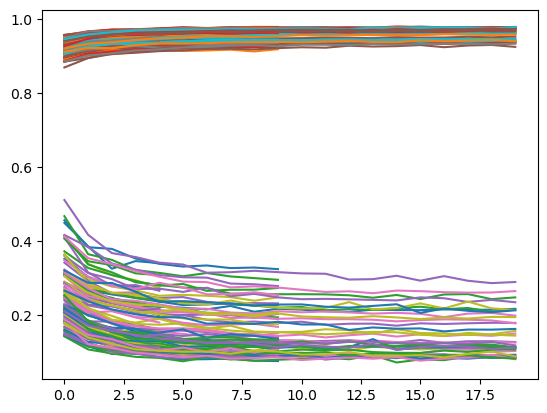

In [11]:
n_camadas_ocultas = [1,2,3]
n_units = [16,32,64]
activation = ['relu','tanh']
drop_out = [0.1, 0.2]
epochs = [5,10,20]

for camadas in n_camadas_ocultas:
    for unidades in n_units:
        for ativacao in activation:
            for drop in drop_out:
                for epocas in epochs:
                    treina_dl(camadas,unidades,ativacao, drop, epocas)